# Importing the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None
from IPython.display import display
from scipy import stats
from scipy.stats import chi2_contingency,f_oneway
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading the dataset

In [3]:
df=pd.read_csv('diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df.shape

(101766, 50)

### Duplicate rows


* We are dropping **'encounter_id' and 'patient_nbr'**, as we want every record to be treated as a new patient irrespective of the visits frequency and encounter_id. So that our **Model can Genearlize** a better pattern in Dataset.

In [5]:
df.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

* The people who died after discharge are not significant for our analysis.So we can remove such records.

In [7]:
df=df[~df['discharge_disposition_id'].isin([11,19,20,21])]
df.reset_index(drop=True,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100114 entries, 0 to 100113
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100114 non-null  object
 1   gender                    100114 non-null  object
 2   age                       100114 non-null  object
 3   weight                    100114 non-null  object
 4   admission_type_id         100114 non-null  int64 
 5   discharge_disposition_id  100114 non-null  int64 
 6   admission_source_id       100114 non-null  int64 
 7   time_in_hospital          100114 non-null  int64 
 8   payer_code                100114 non-null  object
 9   medical_specialty         100114 non-null  object
 10  num_lab_procedures        100114 non-null  int64 
 11  num_procedures            100114 non-null  int64 
 12  num_medications           100114 non-null  int64 
 13  number_outpatient         100114 non-null  int64 
 14  numb

In [9]:
## Function to display percentage along with value counts for each column passed as argument

def count_percentage(column):
    
    display(pd.DataFrame({'count':df[column].value_counts(dropna=False),'percentage':round(df[column].value_counts(normalize=True, dropna=False)*100,3)},
             index=df[column].value_counts(dropna=False).index))

### Checking for missing values

* Here missing values are represented by '?'

In [10]:
missing=pd.DataFrame(columns=['Missing values','Missing percentage'])
for i in df.columns:
    missing.loc[i]=(len(df[df[i]=='?']),len(df[df[i]=='?'])*100/len(df))
missing

,Missing values,Missing percentage
race,2239.0,2.236450
gender,0.0,0.000000
age,0.0,0.000000
weight,96958.0,96.847594
admission_type_id,0.0,0.000000
discharge_disposition_id,0.0,0.000000
admission_source_id,0.0,0.000000
time_in_hospital,0.0,0.000000
payer_code,39591.0,39.545918
medical_specialty,49129.0,49.073057


### Removing insignificant columns

* We are dropping [**Weight, payer_code, medical_specialty**] feature because of substanstial null Values of above **96%,40% and 49%** respectively which induces Bias in dataset if we replace by Mode.

In [11]:
df.drop(['weight','payer_code','medical_specialty'],axis=1,inplace=True)

### Gender column

In [12]:
count_percentage('gender')

,count,percentage
gender,,
Female,53861,53.800
Male,46250,46.197
Unknown/Invalid,3,0.003


* Dropping the unknown/invalid gender category as it is of no significance to our analysis.

In [13]:
df= df.drop(df.loc[df["gender"]=="Unknown/Invalid"].index, axis=0)
df.reset_index(drop=True,inplace=True)
count_percentage('gender')

,count,percentage
gender,,
Female,53861,53.801
Male,46250,46.199


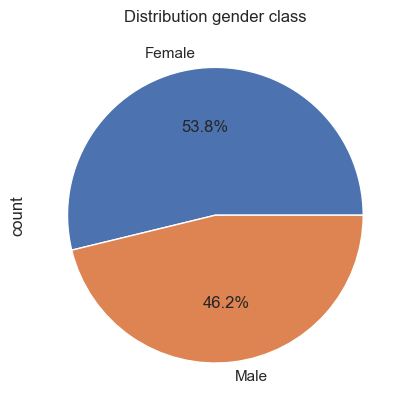

In [14]:
df['gender'].value_counts().plot(kind='pie', title='Distribution gender class',autopct='%1.1f%%');

* Females are having a higher distribution when compared to males in our dataset.

### Age column

In [15]:
count_percentage('age')

,count,percentage
age,,
[70-80),25560,25.532
[60-70),22184,22.159
[50-60),17102,17.083
[80-90),16706,16.687
[40-50),9626,9.615
[30-40),3765,3.761
[90-100),2668,2.665
[20-30),1650,1.648
[10-20),690,0.689


In [16]:
df['age'] = df['age'].replace({"[70-80)":75,"[60-70)":65,"[50-60)":55,"[80-90)":85,"[40-50)":45,
                                 "[30-40)":35,"[90-100)":95,"[20-30)":25,"[10-20)":15,"[0-10)":5})
count_percentage('age')

,count,percentage
age,,
75,25560,25.532
65,22184,22.159
55,17102,17.083
85,16706,16.687
45,9626,9.615
35,3765,3.761
95,2668,2.665
25,1650,1.648
15,690,0.689


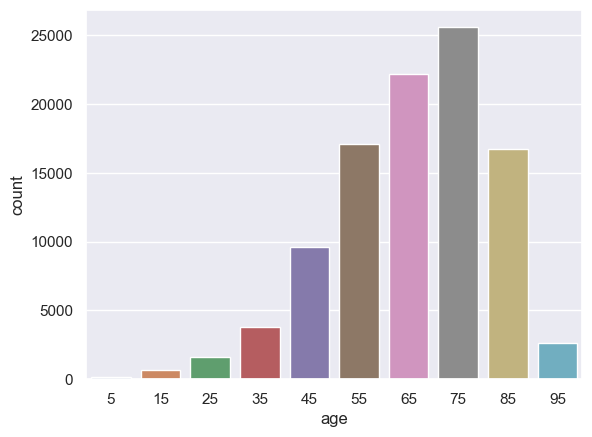

In [17]:
sns.countplot(x="age", data = df)
plt.xticks(rotation=0)
plt.show()

* Most of the patients falls in the age range 50-90 in our dataset.

### Race column

In [18]:
count_percentage('race')

,count,percentage
race,,
Caucasian,74845,74.762
AfricanAmerican,18888,18.867
?,2237,2.235
Hispanic,2024,2.022
Other,1485,1.483
Asian,632,0.631


* Mapping race to five categories i.e., CAUCASIAN, AFRICANAMERICAN, HISPANIC, ASIAN AND OTHERS.

In [19]:
race2 = {'?':'Other'}
df['race'] = df['race'].replace(race2)

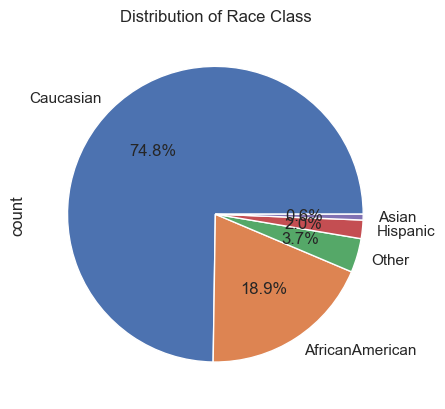

In [20]:
df['race'].value_counts().plot(kind='pie', title='Distribution of Race Class',autopct='%1.1f%%');

### Admission_type_id column

* Various categories in this column:
    
    * Emergency : 1,
    * Urgent : 2,
    * Elective : 3,
    * Newborn : 4,
    * Not Available : 5,
    * NULL : 6,
    * Trauma Center : 7,
    * Not Mapped : 8

* We can club Not Available,NULL and Not Mapped as one category   'Not Available'. Thereby, we have only six categories under Admission_type_id i.e.,Emergency,Urgent,Elective,New Born,Trauma Center and Not Available.

In [21]:
count_percentage('admission_type_id')

,count,percentage
admission_type_id,,
1,52882,52.823
3,18738,18.717
2,18226,18.206
6,5227,5.221
5,4690,4.685
8,320,0.320
7,18,0.018
4,10,0.010


In [22]:
adm = {1.0:"Emergency",
       2.0:"Urgent",
       3.0:"Elective",
       4.0:"New Born",
       5.0:"Not Available",
       6.0:"Not Available",
       7.0:"Trauma Center",
       8.0:"Not Available"}
df['admission_type_id'] = df['admission_type_id'].replace(adm)
count_percentage('admission_type_id')

,count,percentage
admission_type_id,,
Emergency,52882,52.823
Elective,18738,18.717
Urgent,18226,18.206
Not Available,10237,10.226
Trauma Center,18,0.018
New Born,10,0.010


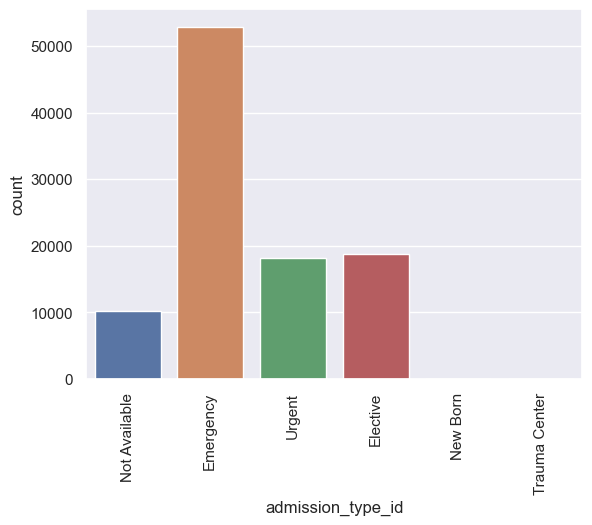

In [23]:
sns.countplot(x = "admission_type_id", data=df)
plt.xticks(rotation=90)
plt.show()

* Most of the patients fall under the emergency category.

### Discharge_disposition_id column

Column description:
* 1	Discharged to home
* 2	Discharged/transferred to another short term hospital
* 3	Discharged/transferred to SNF
* 4	Discharged/transferred to ICF
* 5	Discharged/transferred to another type of inpatient care institution
* 6	Discharged/transferred to home with home health service
* 7	Left AMA
* 8	Discharged/transferred to home under care of Home IV provider
* 9	Admitted as an inpatient to this hospital
* 10	Neonate discharged to another hospital for neonatal aftercare
* 11	Expired
* 12	Still patient or expected to return for outpatient services
* 13	Hospice / home
* 14	Hospice / medical facility
* 15	Discharged/transferred within this institution to Medicare approved swing bed
* 16	Discharged/transferred/referred another institution for outpatient services
* 17	Discharged/transferred/referred to this institution for outpatient services
* 18	NULL
* 19	Expired at home. Medicaid only, hospice.
* 20	Expired in a medical facility. Medicaid only, hospice.
* 21	Expired, place unknown. Medicaid only, hospice.
* 22	Discharged/transferred to another rehab fac including rehab units of a hospital .
* 23	Discharged/transferred to a long term care hospital.
* 24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
* 25	Not Mapped
* 26	Unknown/Invalid
* 30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
* 27	Discharged/transferred to a federal health care facility.
* 28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
* 29	Discharged/transferred to a Critical Access Hospital (CAH).

All the categories which contains the word 'home' are grouped into a category called 'Discharged to Home'.NULL,Not Mapped and Unknown/Invalid are grouped into a category called 'Unknown'.Rest all are grouped into a category called 'Other'.

In [24]:
count_percentage('discharge_disposition_id')

,count,percentage
discharge_disposition_id,,
1,60232,60.165
3,13954,13.939
6,12902,12.888
18,3691,3.687
2,2128,2.126
22,1992,1.990
5,1184,1.183
25,989,0.988
4,815,0.814


In [25]:
discharge = {1:"Discharged to Home",
             6:"Discharged to Home",
             8:"Discharged to Home",
            13:"Discharged to Home",
            18:"Unknown",25:"Unknown",26:"Unknown",
            2:"Other",3:"Care/Nursing",4:"Care/Nursing",
            5:"Care/Nursing",7:"Other",9:"Other",
            10:"Other",11:"Other",12:"Other",
            14:"Care/Nursing",15:"Other",16:"Other",
            17:"Other",20:"Other",21:"Other",
            22:"Care/Nursing",23:"Care/Nursing",24:"Care/Nursing",
            27:"Other",28:"Other",29:"Other",30:"Other"}

df["discharge_disposition_id"] = df["discharge_disposition_id"].replace(discharge)
count_percentage('discharge_disposition_id')

,count,percentage
discharge_disposition_id,,
Discharged to Home,73641,73.559
Care/Nursing,18777,18.756
Unknown,4680,4.675
Other,3013,3.010


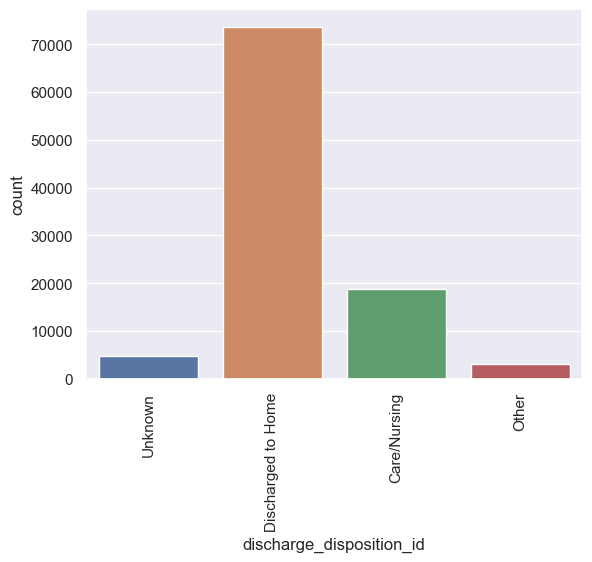

In [26]:
sns.countplot(x = "discharge_disposition_id", data=df)
plt.xticks(rotation=90)
plt.show()

* Majority of the patients were discharged to home.

### Admission_source_id column

Various categories in this column:
* 1	 Physician Referral
* 2	Clinic Referral
* 3	HMO Referral
* 4	Transfer from a hospital
* 5	 Transfer from a Skilled Nursing Facility (SNF)
* 6	 Transfer from another health care facility
* 7	 Emergency Room
* 8	 Court/Law Enforcement
* 9	 Not Available
* 10 Transfer from critial access hospital
* 11 Normal Delivery
* 12 Premature Delivery
* 13 Sick Baby
* 14	 Extramural Birth
* 15	Not Available
* 17	NULL
* 18	 Transfer From Another Home Health Agency
* 19	Readmission to Same Home Health Agency
* 20	 Not Mapped
* 21	Unknown/Invalid
* 22	 Transfer from hospital inpt/same fac reslt in a sep claim
* 23	 Born inside this hospital
* 24	 Born outside this hospital
* 25	 Transfer from Ambulatory Surgery Center
* 26	Transfer from Hospice

In this column, admitted from emergency room, admitted because of someone's referral and admitted from another hospital are the three major categories that contribute to a major portion of the records.So besides these three, we club all the other categories into a separate category called 'others'.

In [27]:
count_percentage('admission_source_id')

,count,percentage
admission_source_id,,
7,56361,56.299
1,29321,29.288
17,6645,6.638
4,3132,3.129
6,2244,2.242
2,1083,1.082
5,814,0.813
3,185,0.185
20,159,0.159


In [28]:
# admission_source_id 1,2,3 are Physician referral,clinic referral and HMO referral respectively.

for i in df['admission_source_id'].unique():
    if i in [1,2,3]:
        df['admission_source_id']=df['admission_source_id'].replace(i,'Referral')
    elif i==4 or i==6:
        df['admission_source_id']=df['admission_source_id'].replace(i,'Transfer from hospital')
    elif i==7:
        df['admission_source_id']=df['admission_source_id'].replace(i,'Emergency room')
    else:
        df['admission_source_id']=df['admission_source_id'].replace(i,'Others')

In [29]:
count_percentage('admission_source_id')

,count,percentage
admission_source_id,,
Emergency room,56361,56.299
Referral,30589,30.555
Others,7785,7.776
Transfer from hospital,5376,5.370


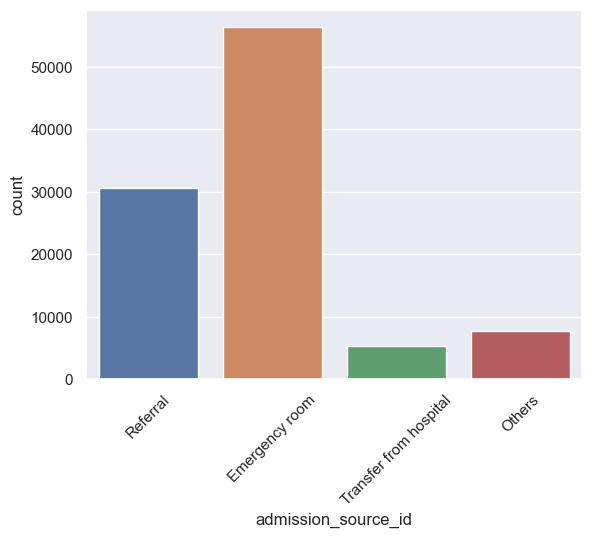

In [30]:
sns.countplot(x = "admission_source_id", data=df)
plt.xticks(rotation=45)
plt.show()

* Around 56% of the patients were admitted from emergency room.

### Handling missing values in diag_1,diag_2,diag3 columns

* diag_1,diag_2 and diag_3 are categorical variables. They have both numeric and alpha-numeric(V45,V57) values.

* Going by the data dictionary, we get to know that these columns are sequentially dependent. So we cant have values of diag_2 unless diag_1 is done. Similarly we cant have diag_3 values unless we have diag_2 values.

In [31]:
# dropping rows that have null values for diag_1 and not null for diag_2 or diag_3
diag1_index=df[(df['diag_1']=='?') & ((df['diag_3'] !='?') | (df['diag_2'] !='?'))].index
df.drop(diag1_index,inplace=True)

In [32]:
# dropping rows that have null values for diag_2 and not null for diag_3
diag2_index=df[(df['diag_2']=='?') & (df['diag_3'] !='?')].index
df.drop(diag2_index,inplace=True)

In [33]:
mode_1=df['diag_1'].mode()[0]
mode_2=df['diag_2'].mode()[0]
mode_3=df['diag_3'].mode()[0]

df['diag_1']=df['diag_1'].replace('?',mode_1)
df['diag_2']=df['diag_2'].replace('?',mode_2)
df['diag_3']=df['diag_3'].replace('?',mode_3)

Since there are many sub-categories in diag_1,diag_2 and diag_3, we cannot apply one hot encoding to the original column. So in order to avoid curse of dimensionality, we will club the similar sub-categories.
From the domain knowledge different ICD values can be clubed as following

Ciculatory --> 390-459,785 --> Diseases of circulatory system

Respiratory --> 460-519,786 --> Diseases of respiratory system

Digestive --> 520-579,787 --> Diseases of digestive system

Diabetes --> 250.xx --> Diabetes mellitus

Injury --> 800-999 --> Injury and poisoning

Musculoskeletal --> 710-7399 --> Disease of musculoskeletal

Genitourinary --> 580–629, 788 -->  Diseases of the genitourinary system 

Neoplasms --> 140–239  -->  Neoplasms 

Pregnecy --> 630–679  --> Complications of pregnancy, childbirth, and the puerperium 

Other

In [34]:
def diagnosis_col(x):
    if str(x).startswith('V')==True or str(x).startswith('E')==True:
        return str(x).replace(str(x),'Others')
    elif (int(float(x)) in range(390,460)) or int(float(x))==785:
        return str(x).replace(str(x),'Circulatory')
    elif (int(float(x)) in range(460,520)) or int(float(x))==786:
        return str(x).replace(str(x),'Respiratory')
    elif int(float(x))==250:
        return str(x).replace(str(x),'Diabetes')
    elif (int(float(x)) in range(800,1000)):
        return str(x).replace(str(x),'Injury')
    elif (int(float(x)) in range(710,740)):
        return str(x).replace(str(x),'Musculoskelatal')
    elif (int(float(x)) in range(580,630)) or int(float(x))==788:
        return str(x).replace(str(x),'Genitourinary')
    elif (int(float(x)) in range(140,240)):
        return str(x).replace(str(x),'Neoplasms')
    else:
        return "Others"

In [35]:
df['diag_1']=df['diag_1'].apply(diagnosis_col)
df['diag_2']=df['diag_2'].apply(diagnosis_col)
df['diag_3']=df['diag_3'].apply(diagnosis_col)

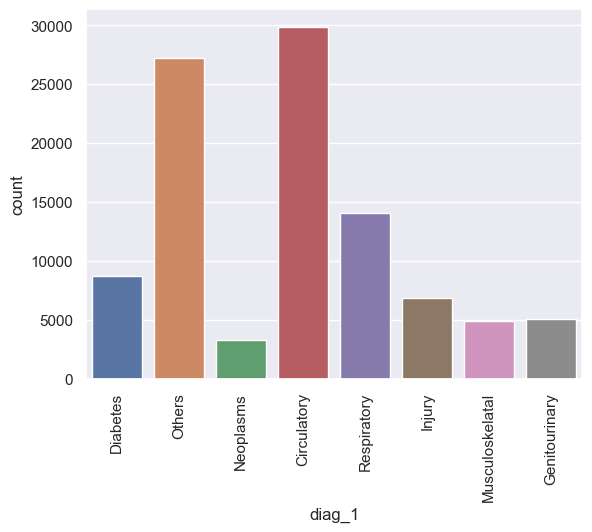

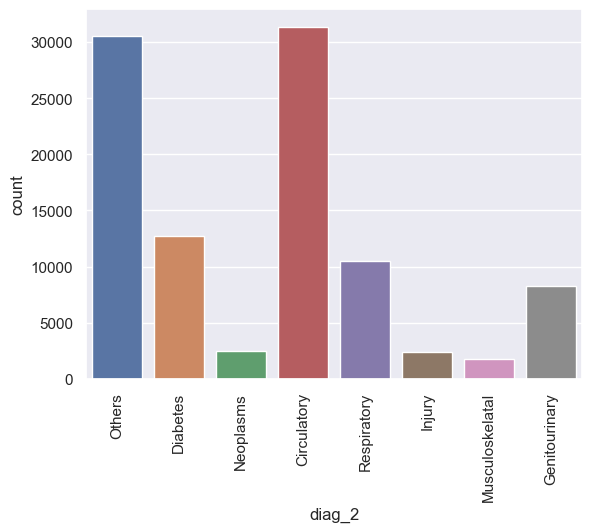

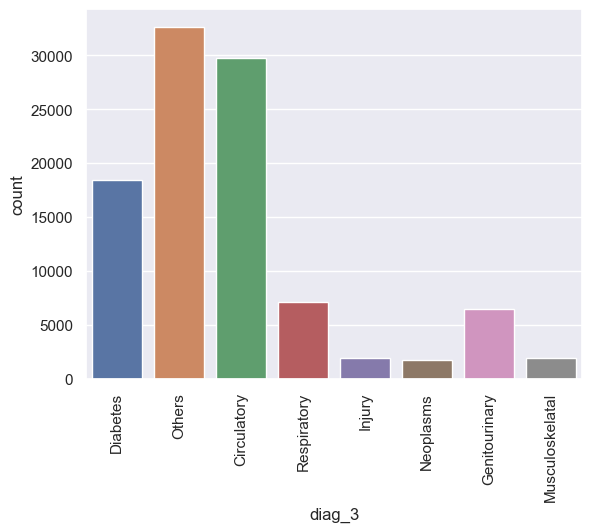

In [36]:
sns.countplot(x = "diag_1", data=df)
plt.xticks(rotation=90)
plt.show()
sns.countplot(x = "diag_2", data=df)
plt.xticks(rotation=90)
plt.show()
sns.countplot(x = "diag_3", data=df)
plt.xticks(rotation=90)
plt.show()

* From the plots, we can see that diagnoses for circulatory is the most common diagnoses that the patients undergo in all the three diagnoses stages.

### Glucose serum test column

* Values tell about various blood sugar levels ranging from normal to greater than 300.

'None' : 0
    
'Norm' : 100 

'>200' : 200  

'>300' : 300    

In [37]:
count_percentage('max_glu_serum')

,count,percentage
max_glu_serum,,
NaN,94789,94.778
Norm,2572,2.572
>200,1440,1.440
>300,1211,1.211


<Axes: xlabel='max_glu_serum'>

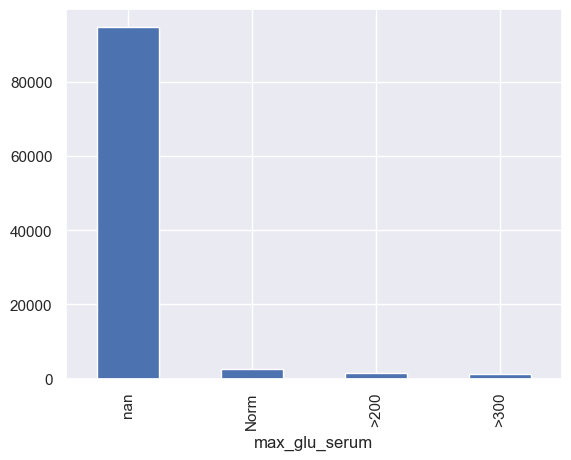

In [38]:
df['max_glu_serum'].value_counts(dropna=False).plot(kind='bar')

* There is **sparsity** in this column which indeed add **bias** for the model.We will deal with such sparse column in **feature engineering**
* The upcoming features A1Cresult and all the medications columns also has this sparsity problem which will also be dealt in the feature selection stage.

### A1Cresult column

* These values show the average blood glucose level of patient over past 3 months. Here individual values are important for analysis so we do the following changes

'None': 0

'>8'  : 8

'Norm': 5

'>7'  : 7

In [39]:
count_percentage('A1Cresult')

,count,percentage
A1Cresult,,
NaN,83150,83.140
>8,8147,8.146
Norm,4936,4.935
>7,3779,3.779


<Axes: xlabel='A1Cresult'>

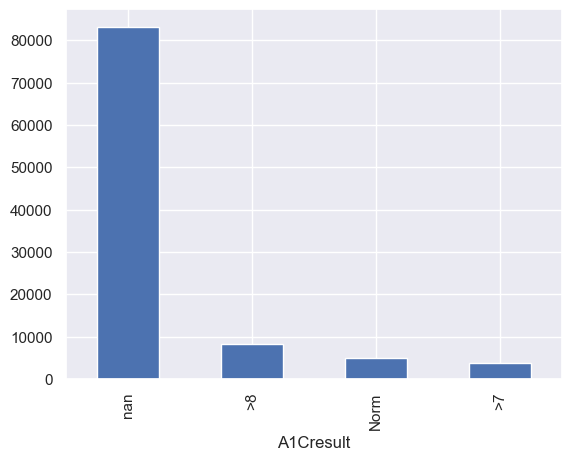

In [40]:
df['A1Cresult'].value_counts(dropna=False).plot(kind='bar')

* Sparsity is clearly visible in this plot also.

### Features of  Medicine Precribed   from **metformin** to **metformin-pioglitazone**

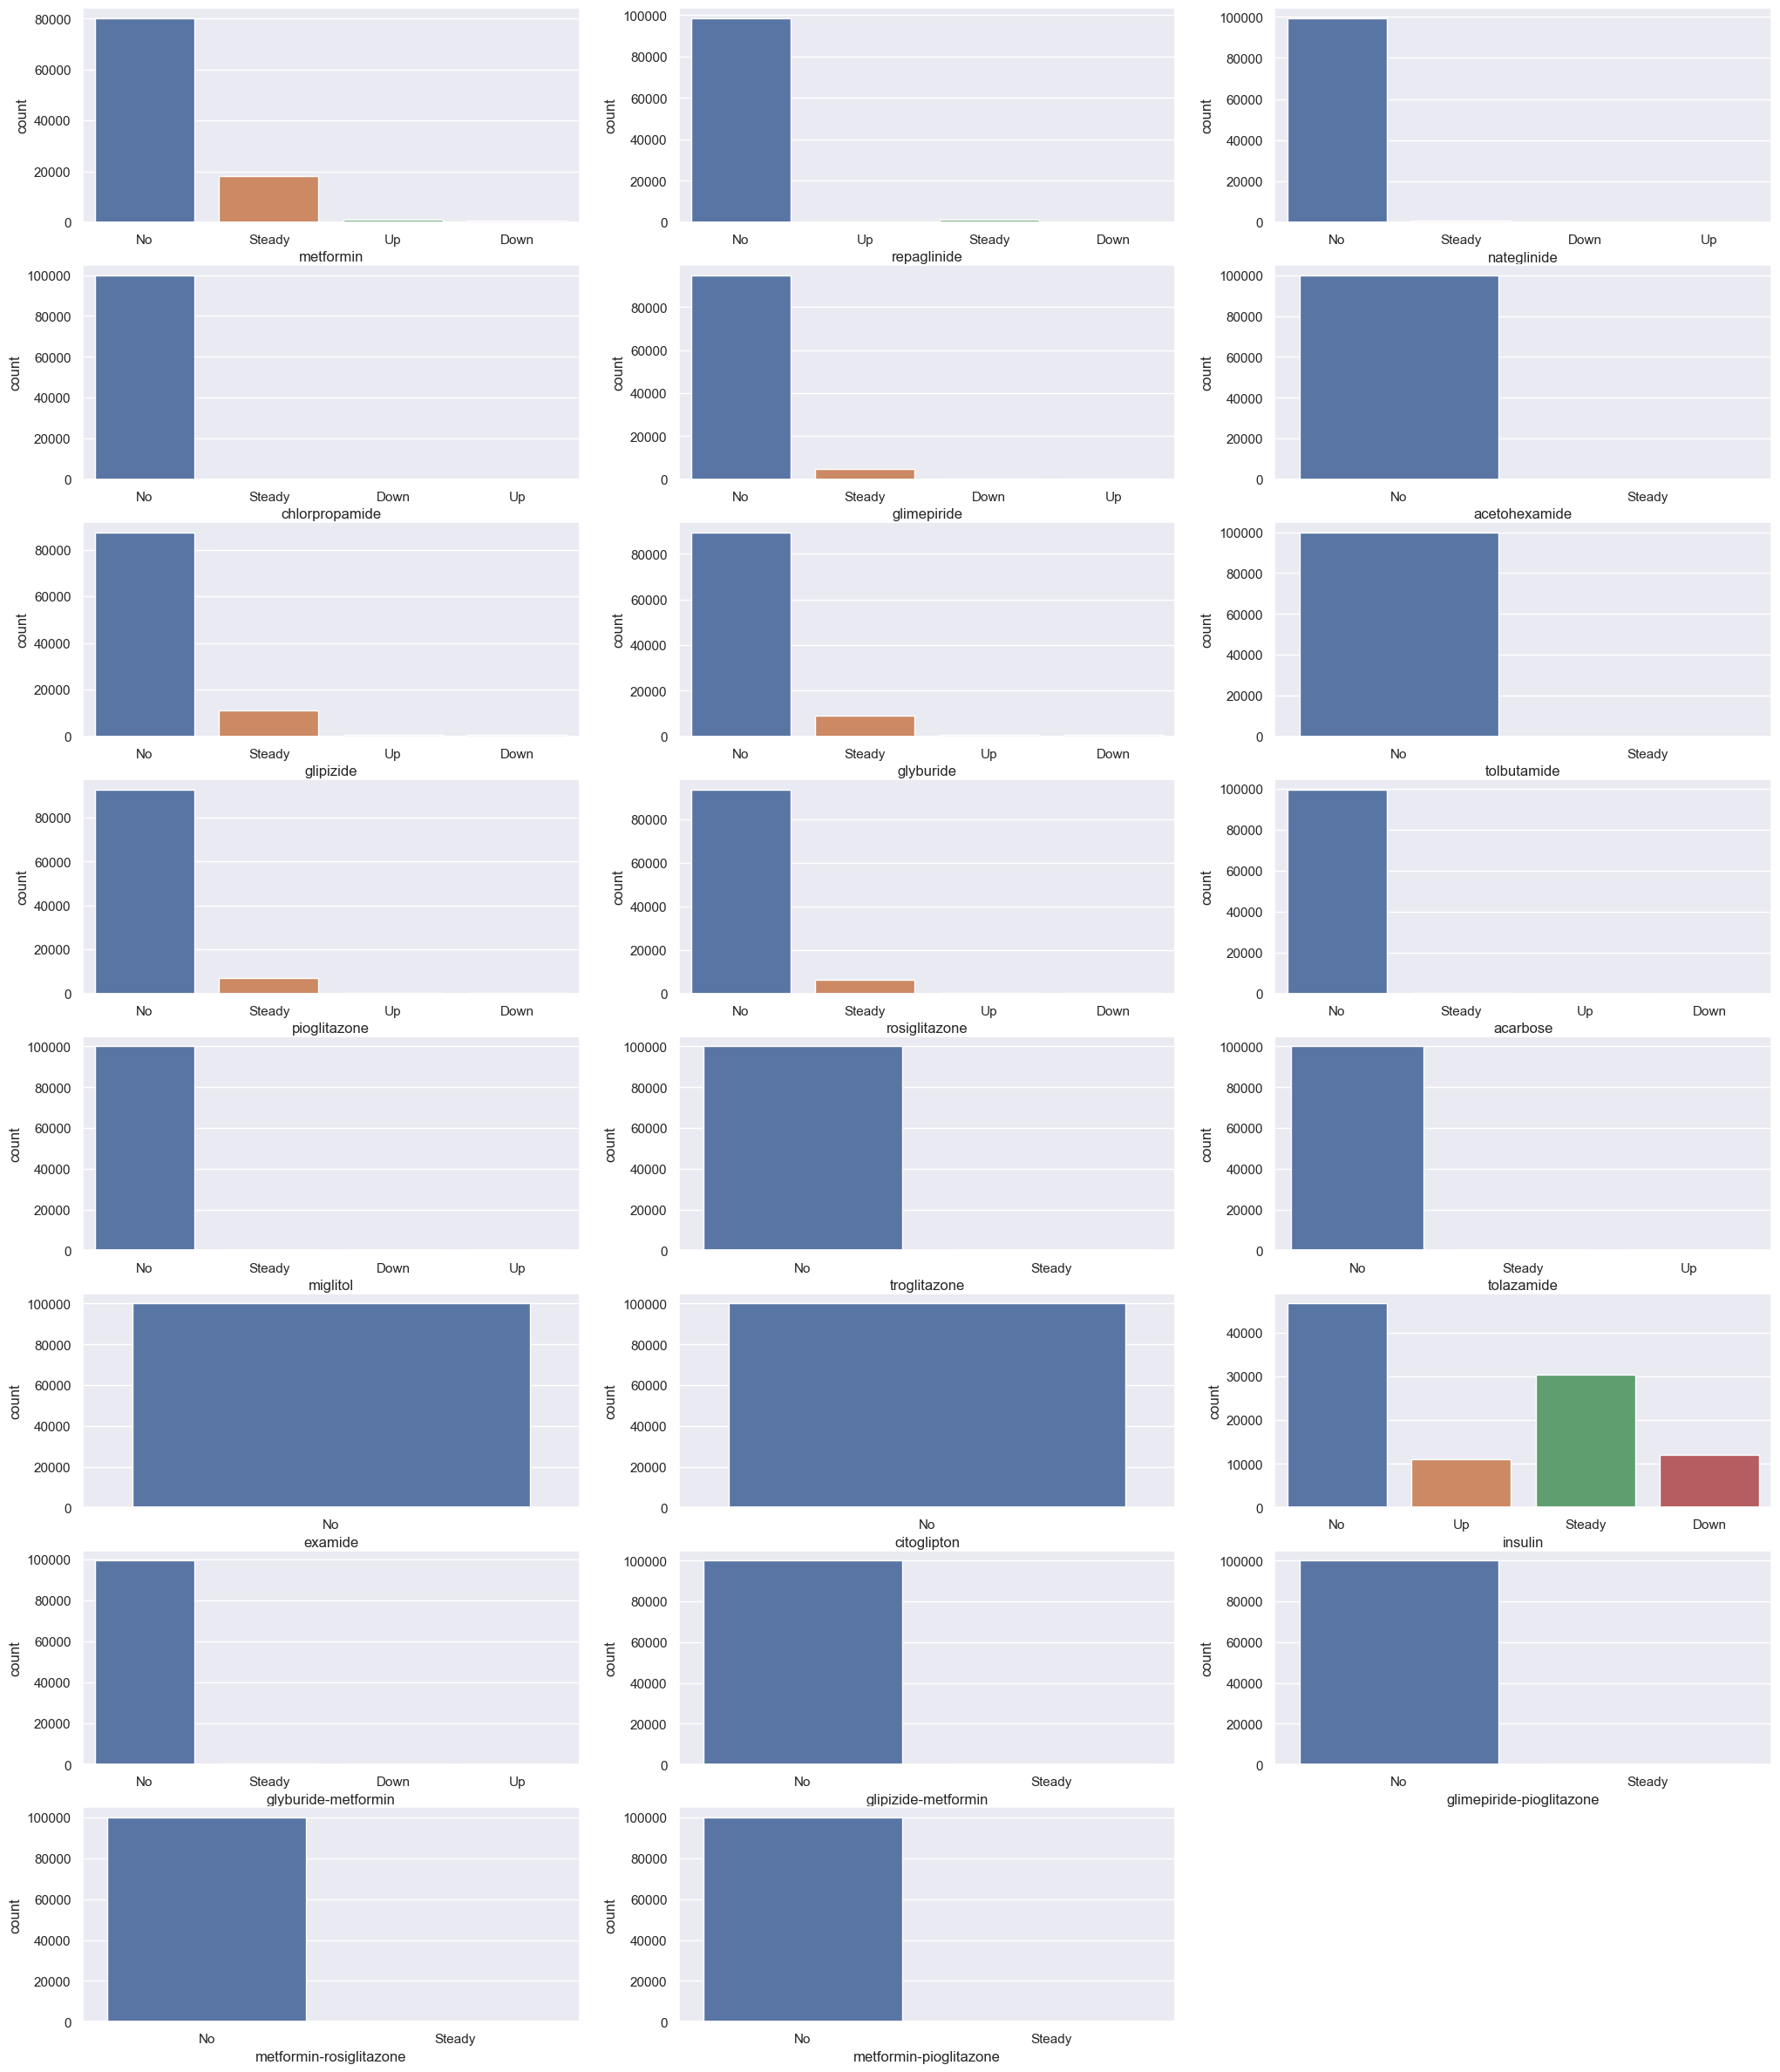

In [41]:
#  Categorical Data
a = 8  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(25, 30))

for i in df.loc[ : , "metformin":"metformin-pioglitazone"].columns:
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.countplot(x= df[i])
    c = c + 1

plt.show()

In the Above graph, The columns **[examide, citoglipton, glimepiride-pioglitazone]** have only 1 category , so we will not use these features as these are not significant for our analysis.

In [42]:
for col in ['examide', 'citoglipton', 'glimepiride-pioglitazone']:
    print(df[col].value_counts())
    print('\n')

examide
No    100012
Name: count, dtype: int64


citoglipton
No    100012
Name: count, dtype: int64


glimepiride-pioglitazone
No        100011
Steady         1
Name: count, dtype: int64




In [43]:
df = df.drop(['examide', 'citoglipton','glimepiride-pioglitazone'], axis = 1)

In [44]:
for col in df.loc[ : , "metformin":"metformin-pioglitazone"].columns:
    count_percentage(col)
    print("Column:",col )
    print('\n')

,count,percentage
metformin,,
No,80137,80.127
Steady,18236,18.234
Up,1065,1.065
Down,574,0.574


Column: metformin




,count,percentage
repaglinide,,
No,98485,98.473
Steady,1373,1.373
Up,109,0.109
Down,45,0.045


Column: repaglinide




,count,percentage
nateglinide,,
No,99318,99.306
Steady,659,0.659
Up,24,0.024
Down,11,0.011


Column: nateglinide




,count,percentage
chlorpropamide,,
No,99927,99.915
Steady,78,0.078
Up,6,0.006
Down,1,0.001


Column: chlorpropamide




,count,percentage
glimepiride,,
No,94873,94.862
Steady,4622,4.621
Up,324,0.324
Down,193,0.193


Column: glimepiride




,count,percentage
acetohexamide,,
No,100011,99.999
Steady,1,0.001


Column: acetohexamide




,count,percentage
glipizide,,
No,87420,87.410
Steady,11272,11.271
Up,766,0.766
Down,554,0.554


Column: glipizide




,count,percentage
glyburide,,
No,89453,89.442
Steady,9194,9.193
Up,805,0.805
Down,560,0.560


Column: glyburide




,count,percentage
tolbutamide,,
No,99991,99.979
Steady,21,0.021


Column: tolbutamide




,count,percentage
pioglitazone,,
No,92744,92.733
Steady,6922,6.921
Up,229,0.229
Down,117,0.117


Column: pioglitazone




,count,percentage
rosiglitazone,,
No,93691,93.680
Steady,6062,6.061
Up,173,0.173
Down,86,0.086


Column: rosiglitazone




,count,percentage
acarbose,,
No,99705,99.693
Steady,294,0.294
Up,10,0.010
Down,3,0.003


Column: acarbose




,count,percentage
miglitol,,
No,99975,99.963
Steady,31,0.031
Down,4,0.004
Up,2,0.002


Column: miglitol




,count,percentage
troglitazone,,
No,100009,99.997
Steady,3,0.003


Column: troglitazone




,count,percentage
tolazamide,,
No,99973,99.961
Steady,38,0.038
Up,1,0.001


Column: tolazamide




,count,percentage
insulin,,
No,46626,46.620
Steady,30301,30.297
Down,12001,12.000
Up,11084,11.083


Column: insulin




,count,percentage
glyburide-metformin,,
No,99316,99.304
Steady,682,0.682
Up,8,0.008
Down,6,0.006


Column: glyburide-metformin




,count,percentage
glipizide-metformin,,
No,99999,99.987
Steady,13,0.013


Column: glipizide-metformin




,count,percentage
metformin-rosiglitazone,,
No,100010,99.998
Steady,2,0.002


Column: metformin-rosiglitazone




,count,percentage
metformin-pioglitazone,,
No,100011,99.999
Steady,1,0.001


Column: metformin-pioglitazone




### Readmitted column (Target variable)

In [45]:
df['readmitted'].value_counts()

readmitted
NO     53160
>30    35511
<30    11341
Name: count, dtype: int64

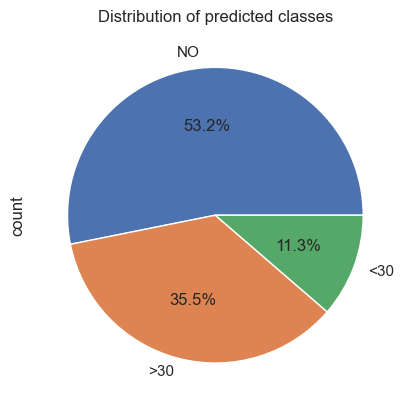

In [46]:
df['readmitted'].value_counts().plot(kind='pie', title='Distribution of predicted classes',autopct='%1.1f%%')
plt.show()

* From the plot, we can observe that around 47 percent of the patients were readmitted.

# Exploratory Data Analysis

## Univariate Analysis

#### Changes In Mediactions

In [124]:
df[(df['insulin'] == 'Up') | (df['insulin'] == 'Down')]['change'].value_counts()

change
Ch    23085
Name: count, dtype: int64

In [125]:
df[df['change'] == 'Ch']['diabetesMed'].value_counts()

diabetesMed
Yes    46392
Name: count, dtype: int64

In [126]:
Medicine_proportion_prescribed = []
for col in df.loc[ : , "metformin":"metformin-pioglitazone"].columns:
    Medicine_proportion_prescribed.append(len(df[df[col].isin(['Up','Down'])])/ len(df) * 100)

print(pd.Series(Medicine_proportion_prescribed,index= df.loc[ : , "metformin":"metformin-pioglitazone"].columns).head(9))

metformin         1.638803
repaglinide       0.153982
nateglinide       0.034996
chlorpropamide    0.006999
glimepiride       0.516938
acetohexamide     0.000000
glipizide         1.319842
glyburide         1.364836
tolbutamide       0.000000
dtype: float64


 * <font color='green'>Inference: While **Insulin** level of a person is **fluctuating**(i.e Up or Down),there is a **Change in Medication**, which mostly Comprises of **( Metaformin(1.6%) , glyburide(1.4%), glipizide(1.3%))**.</font>

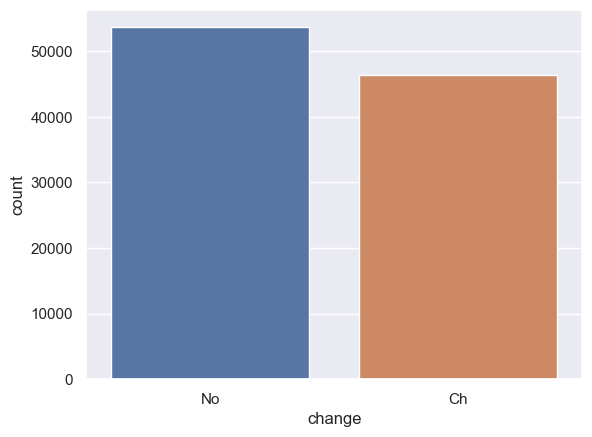

In [128]:
sns.countplot(x= df['change'])
plt.savefig('Changecolumn')

In [ ]:
df['change'].value_counts(normalize=True)*100

No    53.613566
Ch    46.386434
Name: change, dtype: float64

* <font color='green'>Above analysis shows the **changes in medication** of the patient.Graph shows that around **46% of the patients** were observed with change in their diabetic routine medications.</font>

### Readmitted column

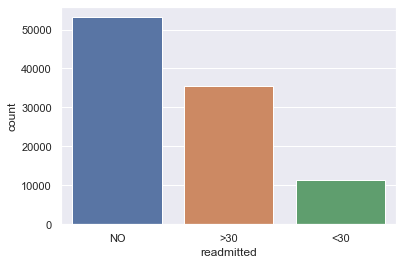

In [ ]:
sns.countplot(df['readmitted'])
plt.savefig('Readmittedcolumn')

In [ ]:
count_percentage('readmitted')

,count,percentage
NO,53160,53.154
>30,35511,35.507
<30,11341,11.340


* <font color='green'>Above plot dictates the readmission figures.From our data only **11% of the patients** were readmitted within **30 days** and **35% after 30 days**.Also there is **53% of population** which remained **unaffected of readmission** due to diabetic conditions.</font>

### A1Cresult column

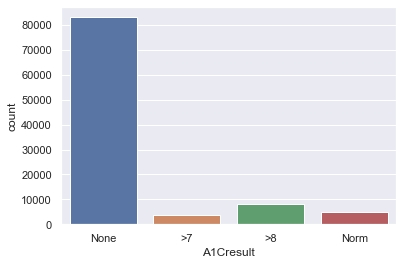

In [ ]:
sns.countplot(df['A1Cresult'])
plt.savefig('A1Cresultcolumn')

In [ ]:
df['A1Cresult'].value_counts(normalize=True)*100

None    83.140023
>8       8.146022
Norm     4.935408
>7       3.778547
Name: A1Cresult, dtype: float64

* <font color='green'>A1C test results denotes the average blood sugar level of the patient.
Here, it is distributed in ranges where **above 6.5 denotes** that the **patient is diabetic**.It also indicates that around **12% of samples from our dataset are diabetic**.
Apart from that, we have majority of unmeasured values in the dataset imputed as none.</font>

### DiabetesMed column

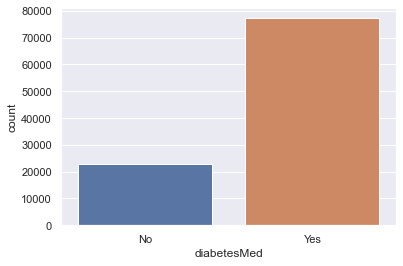

In [ ]:
sns.countplot(df['diabetesMed'])
plt.savefig('diabetesMedcolumn')

In [ ]:
df['diabetesMed'].value_counts(normalize=True)*100

Yes    77.182738
No     22.817262
Name: diabetesMed, dtype: float64

* <font color='green'>We can observe from plot that around **77% of samples from our data take diabetes medicines**.</font>

## Biivariate Analysis

### Heatmap

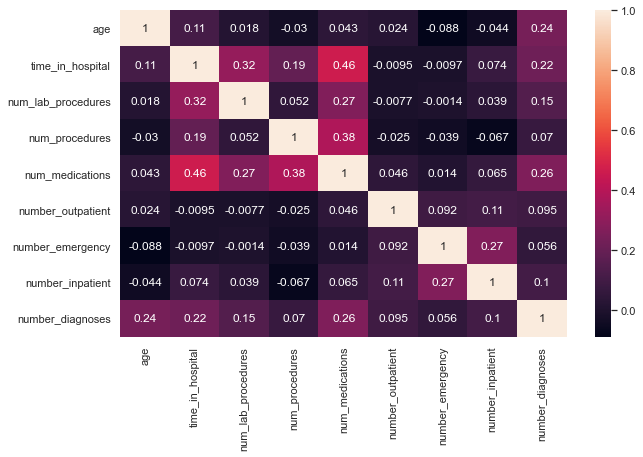

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)
plt.savefig('Heatmap')

* <font color='green'>From the above **Heatmap** we can say that there is no strong  **Correlation** among the independent features.</font>

In [ ]:
pd.crosstab(df['metformin-rosiglitazone'],df['acetohexamide'])

acetohexamide,No,Steady
metformin-rosiglitazone,,
No,100009,1
Steady,2,0


* <font color='green'>AS the proportion in the categorical features *'metformin-rosiglitazone' & 'acetohexamide'* are same(from the crosstab) we can say that these two features are **highly Correlated**.Features like this, which are correlated will be taken care in the feature selection stage.</font>

### Gender vs Readmitted

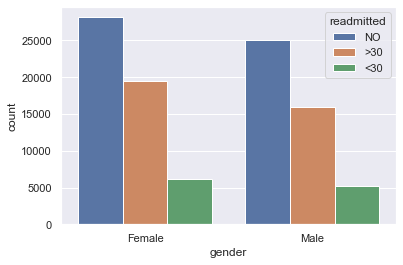

In [ ]:
sns.countplot(x='gender',hue='readmitted',data=df)
plt.savefig('Gender vs Readmitted')

In [ ]:
df_gender=pd.crosstab(df['gender'],df['readmitted'])
df_gender

readmitted,<30,>30,NO
gender,,,
Female,6145,19506,28163
Male,5196,16005,24997


In [ ]:
chances_of_readmission=[]
for i in range(0,len(df_gender)):
    chance=(df_gender.iloc[i][0]/df_gender.iloc[i].sum())*100
    chances_of_readmission.append(chance)

In [ ]:
df_gender['Chance of Readmission%']=chances_of_readmission
df_gender=df_gender.sort_values(by=['Chance of Readmission%'],ascending=False)
df_gender

readmitted,<30,>30,NO,Chance of Readmission%
gender,,,,
Female,6145,19506,28163,11.418962
Male,5196,16005,24997,11.247240


* <font color='green'>We can see from the above plot, the **proportion of males readmitted is almost equal to females**, 
although females are little more prone to be readmitted than males.</font>

### Age vs Readmitted

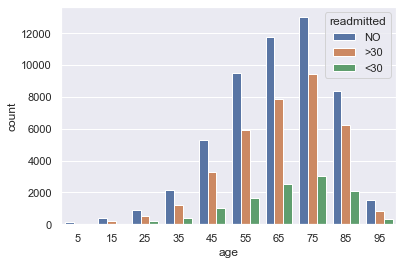

In [ ]:
sns.countplot(x='age',hue='readmitted',data=df)
plt.savefig('Age vs Readmitted')

In [ ]:
df_age=pd.crosstab(df['age'],df['readmitted'])
df_age

readmitted,<30,>30,NO
age,,,
5,3,26,131
15,40,223,426
25,236,509,904
35,423,1186,2154
45,1026,3276,5315
55,1668,5915,9512
65,2500,7887,11769
75,3064,9468,13004
85,2072,6213,8395


In [ ]:
chances_of_readmission=[]
for i in range(0,len(df_age)):
    chance=(df_age.iloc[i][0]/df_age.iloc[i].sum())*100
    chances_of_readmission.append(chance)

In [ ]:
df_age['Chance of Readmission%']=chances_of_readmission
df_age=df_age.sort_values(by=['Chance of Readmission%'],ascending=False)
df_age

readmitted,<30,>30,NO,Chance of Readmission%
age,,,,
25,236,509,904,14.311704
85,2072,6213,8395,12.422062
75,3064,9468,13004,11.998747
95,309,808,1550,11.586052
65,2500,7887,11769,11.283625
35,423,1186,2154,11.241031
45,1026,3276,5315,10.668608
55,1668,5915,9512,9.757239
15,40,223,426,5.805515


* <font color='green'>From the above plot and analysis over age, we can conclude that though we have our **mostly affected population to be elderly**
but we **cannot underrate** the **mid-age generation(i.e 20-40)** because it also associates cosiderable ratio of affected cases.</font>

### Race vs Readmitted

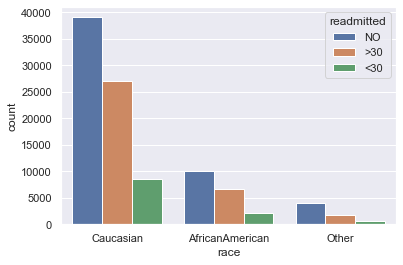

In [ ]:
sns.countplot(x='race',hue='readmitted',data=df)
plt.savefig('Race vs Readmitted')

In [ ]:
df_race=pd.crosstab(df['race'],df['readmitted'])
df_race

readmitted,<30,>30,NO
race,,,
AfricanAmerican,2154,6629,10090
Caucasian,8580,27097,39096
Other,607,1785,3974


In [ ]:
chances_of_readmission=[]
for i in range(0,len(df_race)):
    chance=(df_race.iloc[i][0]/df_race.iloc[i].sum())*100
    chances_of_readmission.append(chance)

In [ ]:
df_race['Chance of Readmission%']=chances_of_readmission
df_race=df_race.sort_values(by=['Chance of Readmission%'],ascending=False)
df_race

readmitted,<30,>30,NO,Chance of Readmission%
race,,,,
Caucasian,8580,27097,39096,11.47473
AfricanAmerican,2154,6629,10090,11.41313
Other,607,1785,3974,9.53503


* <font color='green'>The above analysis indicates that although we have our **most of the population to be "Caucasians"**,
but the **readmission chances of rest of the races** are almost **similar**.</font>

### Admission Source Vs Readmitted

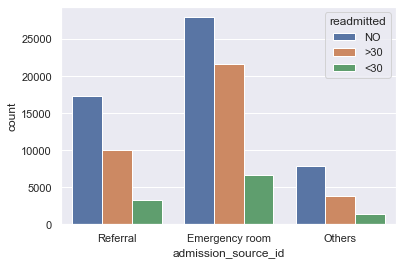

In [ ]:
sns.countplot(x='admission_source_id',hue='readmitted',data=df)
plt.savefig('admission_source_id vs Readmitted')

In [ ]:
df_adm=pd.crosstab(df['admission_source_id'],df['readmitted'])
df_adm

readmitted,<30,>30,NO
admission_source_id,,,
Emergency room,6713,21646,27961
Others,1366,3867,7914
Referral,3262,9998,17285


In [ ]:
chances_of_readmission=[]
for i in range(0,len(df_adm)):
    chance=(df_adm.iloc[i][0]/df_adm.iloc[i].sum())*100
    chances_of_readmission.append(chance)

In [ ]:
df_adm['Chance of Readmission%']=chances_of_readmission
df_adm=df_adm.sort_values(by=['Chance of Readmission%'],ascending=False)
df_adm

readmitted,<30,>30,NO,Chance of Readmission%
admission_source_id,,,,
Emergency room,6713,21646,27961,11.919389
Referral,3262,9998,17285,10.679326
Others,1366,3867,7914,10.390203


* <font color='green'>Although we have data **imbalance among admission_source_id** categories,
the chances of **readmission** are almost **close to each other**.</font>

### Number of Lab Procedures Vs Readmitted

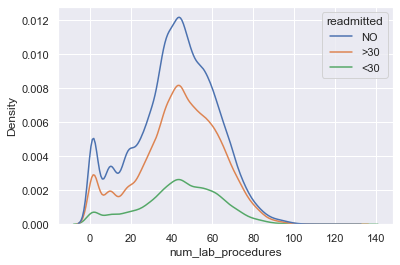

In [ ]:
sns.kdeplot(df['num_lab_procedures'],hue=df['readmitted'])
plt.savefig('num_lab_procedures vs Readmitted')

In [ ]:
df.groupby('readmitted')[['num_lab_procedures']].mean()

,num_lab_procedures
readmitted,
<30,44.231726
>30,43.837346
NO,42.075602


* <font color='green'>The plot above shows the **variance** among number of **lab procedures** with respect to readmission,
we see an insightful distribution of number of lab procedures among readmission of patient.**Irrespective of the number of lab procedures, there are considerable chances of readmission of patient**.</font>

### Number of Diagnoses Vs Readmission

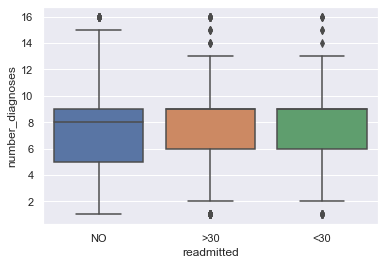

In [ ]:
sns.boxplot(df['readmitted'],df['number_diagnoses'])
plt.savefig('number_diagnoses vs Readmitted')

* <font color='green'>From Boxplots above we can infer that although the distribution of number of diagnoses is not similar,
the median for all categories in readmission is almost similar.
Thus we can conclude that **readmission** is **independent** of the number of **diagnoses**.</font>


### Diagnoses  Vs  Number of Procedures

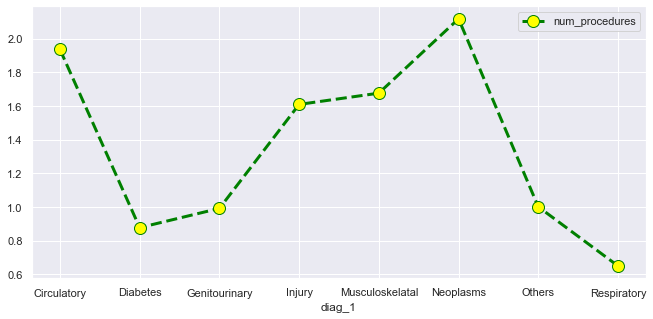

<Figure size 432x288 with 0 Axes>

In [ ]:
df.groupby('diag_1')[['num_procedures']].mean().plot(kind='line',color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='yellow', markersize=12,figsize=(11,5))
plt.show()
plt.savefig('diag_1 vs num_procedures')

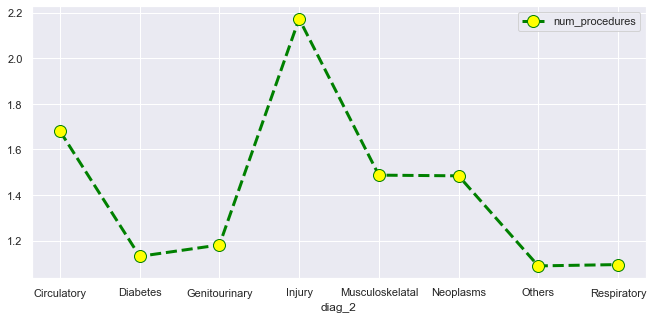

<Figure size 432x288 with 0 Axes>

In [ ]:
df.groupby('diag_2')[['num_procedures']].mean().plot(kind='line',color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='yellow', markersize=12,figsize=(11,5))
plt.show()
plt.savefig('diag_2 vs num_procedures')

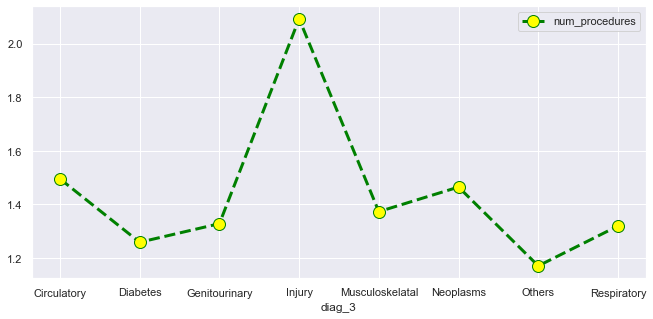

<Figure size 432x288 with 0 Axes>

In [ ]:
df.groupby('diag_3')[['num_procedures']].mean().plot(kind='line',color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='yellow', markersize=12,figsize=(11,5))
plt.show()
plt.savefig('diag_3 vs num_procedures')

* <font color='green'>From the plots above, we can see that the number of procedures for **Diagnosis of Circulatory and Injury** were consistently **high** comparing to others.
So, patients with these diseases **(Circulatory and Injury)** along with diabetes are prone to be readmitted.</font>


### Race  Vs  Time in Hospital

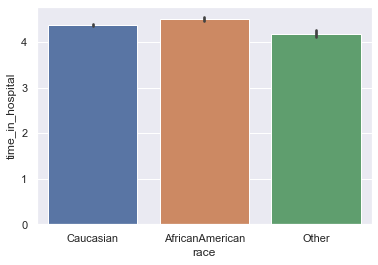

In [ ]:
sns.barplot(df['race'],df['time_in_hospital'])
plt.savefig('race vs time_in_hospital')

* <font color='green'>Irrespective of the race, the time spent by patients is almost similar.But **AfricanAmericans** are more likely to spend more time than caucasian followed by other race.</font>

### Diagnoses  Vs  Readmission

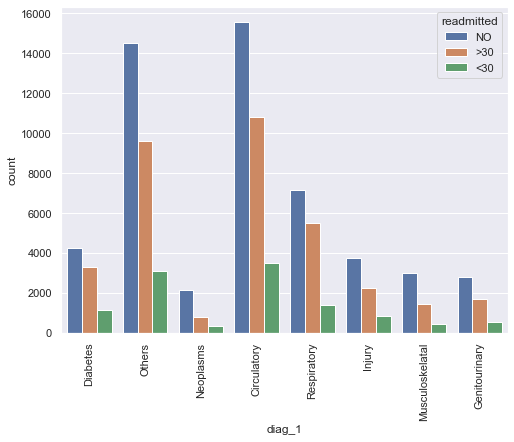

Percentage of categories:

readmitted             <30        >30         NO
diag_1                                          
Circulatory      11.665048  36.267452  52.067499
Diabetes         13.084005  38.158803  48.757192
Genitourinary    10.968125  33.953673  55.078202
Injury           12.416107  32.623286  54.960607
Musculoskelatal   9.508396  29.759256  60.732349
Neoplasms        10.494389  24.234152  65.271459
Others           11.363970  35.295845  53.340185
Respiratory       9.974406  39.286222  50.739372
-----------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

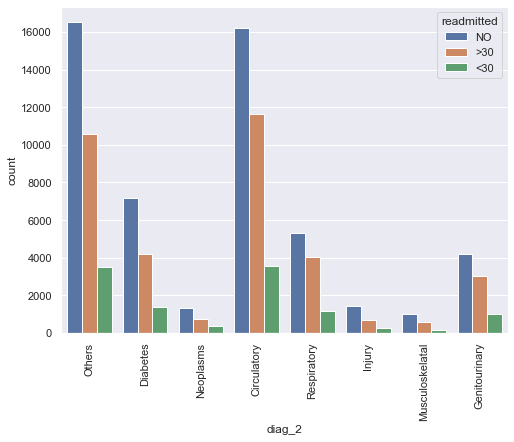

Percentage of categories:

readmitted             <30        >30         NO
diag_2                                          
Circulatory      11.282558  37.093123  51.624319
Diabetes         10.637629  32.990015  56.372356
Genitourinary    11.954805  36.763455  51.281740
Injury           11.646418  28.278173  60.075408
Musculoskelatal  10.045403  33.768445  56.186152
Neoplasms        15.497553  29.893964  54.608483
Others           11.389715  34.613750  53.996535
Respiratory      10.909091  38.676821  50.414089
-----------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

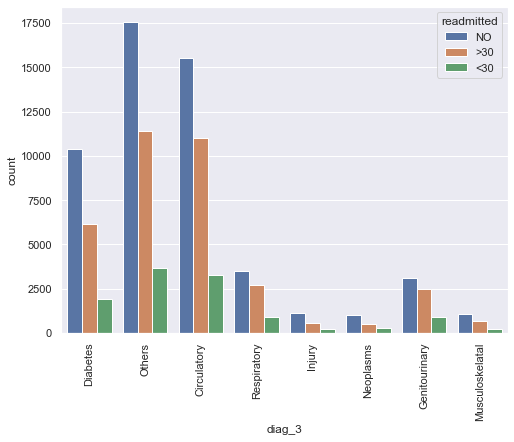

Percentage of categories:

readmitted             <30        >30         NO
diag_3                                          
Circulatory      10.987165  36.909482  52.103353
Diabetes         10.309446  33.387622  56.302932
Genitourinary    13.801044  38.363525  47.835431
Injury           11.835876  30.089427  58.074698
Musculoskelatal  10.725552  34.016824  55.257624
Neoplasms        14.858757  28.757062  56.384181
Others           11.313243  34.971824  53.714933
Respiratory      12.508814  38.499506  48.991680
-----------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:
for col in ['diag_1', 'diag_2', 'diag_3']:
    plt.figure(figsize=(8,6))
    sns.countplot(df[col],hue=df['readmitted'])
    plt.xticks(rotation = 90)
    plt.show()
    plt.savefig(col+' vs readmitted')
    a=pd.crosstab(df[col],df['readmitted'])
    for i in a.index:
        a.loc[i]=a.loc[i]*100/len(df[df[col]==i])
    print('Percentage of categories:\n')    
    print(a)  
    print('-----------------------------------------------------------------------------------')

* <font color='green'>Above plots and analysis indicates that, when compared in all three diagnoses the patients diagonsed with **Circulatory and Respiratory** diseases are **more likely** to get **readmitted** as compared to other.</font>

## Multivariate Analysis

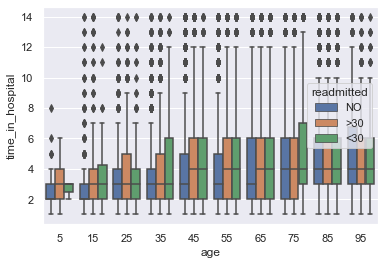

In [ ]:
sns.boxplot(df['age'],df['time_in_hospital'],hue=df['readmitted'])
plt.savefig('Multivariateanalysis')

* <font color='green'>From the above plot we can see that as the **age of the patients increases**,the **time they spent in the hospital also increases** upto a point ,along with chances of getting readmitted.</font>

# Base model building

In [47]:
# Libraries required 
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,MinMaxScaler,PowerTransformer,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_validate,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Labeling target variable
df['readmitted']=df['readmitted'].apply(lambda x:0 if x=='NO'
                       else (1 if x=='>30'
                            else 2))

In [49]:
# Resetting the indices
df=df.reset_index(drop=True)

In [50]:
df_copy=df.copy()

In [51]:
# Labeling medicine columns
for col in df.loc[:,"metformin":'metformin-pioglitazone'].columns:
    df[col] = df[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))

### Splitting numerical and categorical columns of data

Here we are building our baseline model and checking its performance with two different changes in our dataset:
* 1. By **label encoding the medication columns**, which have sub-categories like up,steady,down and no.
* 2. By one-hot encoding the sub-categories in **medication columns using pandas get_dummies**.

#### The following dataframes df_num and df_cat represent the first situation (Label encoding)

In [52]:
df_num=df.drop('readmitted',axis=1).select_dtypes(include=[np.number])
df_cat=df.select_dtypes(include=[np.object_])

#### Dataframes df_num_copy,df_cat_copy represent second situation,where medicienes are not converted to numerical data

In [53]:
df_num_copy=df_copy.drop('readmitted',axis=1).select_dtypes(include=[np.number])
df_cat_copy=df_copy.select_dtypes(include=[np.object_])

Important Note:
* As the scaling methods affect model performace significantly, so in upcoming code we are exploring various scaling methods for our base models.
* Two base models are:
    * **LogisticRegression**
    * **RandomForest**

#### Following base models are build on Label encoded medication columns

In [54]:
# Scaling numerical data using different scalers
scalers_list={'Standard' : StandardScaler(),'MaxAbs' :MaxAbsScaler(),'MinMax' :MinMaxScaler()
              ,'Power' :PowerTransformer(),'Robust' :RobustScaler()}
scaled_dfs={}
for name,scaler in scalers_list.items():
    scaled_features = scaler.fit_transform(df_num)
    df_scaled=pd.DataFrame(scaled_features,columns=df_num.columns)
    scaled_dfs[name] = df_scaled

In [55]:
# Creating dummies of categorical data
df_cat_dummy=pd.get_dummies(df_cat,drop_first=True)

* In **LogisticRegression()**, the default value of parameter **multi_class** is **'auto'** which performs **multinomial logistic regression** in case of multiclass classification. 

In [56]:
cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
df_scores_LR = pd.DataFrame(columns=['LR_f1_score', 'LR_recall', 'LR_precision'])
df_scores_RF = pd.DataFrame(columns=['RF_f1_score', 'RF_recall', 'RF_precision'])
i = 0

models={'Logistic' :LogisticRegression(),'Random_Forest': RandomForestClassifier(n_estimators=30)}
for name,data_frame in scaled_dfs.items():
    #inside 1st loop selecting Scaled_data_frame
    df_ind=pd.concat([data_frame,df_cat_dummy],axis=1)
    X=df_ind
    y=df['readmitted']
    for model_name, model in models.items():
        #inside 2nd loop Selecting model
        cvs=cross_validate(model,X,y,cv=cv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
         
        if model_name == 'Logistic':
            df_scores_LR.loc[i] = [cvs['test_f1_weighted'].mean(), cvs['test_recall_weighted'].mean()
                            ,cvs['test_precision_weighted'].mean()]
            
        else:
            df_scores_RF.loc[i] = [cvs['test_f1_weighted'].mean(), cvs['test_recall_weighted'].mean()
                            ,cvs['test_precision_weighted'].mean()]
    i = i + 1


In [57]:
print("Various metrics for the base models are")
df_res = pd.concat([df_scores_LR, df_scores_RF],axis=1)
df_res.index = ['Standard_scaler','Min_Max_scaler','Max_abs_scaler','Robust_scaler','Power_transformer']
df_res.style.highlight_max(color = 'lightgreen', axis = 0)

Various metrics for the base models are


,LR_f1_score,LR_recall,LR_precision,RF_f1_score,RF_recall,RF_precision
Standard_scaler,0.510800,0.572821,0.543452,0.514952,0.561383,0.523320
Min_Max_scaler,0.507958,0.572081,0.546387,0.517015,0.562912,0.527891
Max_abs_scaler,0.508461,0.571681,0.541262,0.517332,0.562772,0.528538
Robust_scaler,0.521080,0.573621,0.529003,0.516156,0.561103,0.524996
Power_transformer,0.511089,0.572561,0.543725,0.515544,0.561563,0.526380


* Highest values in each column are highlighted for easy interpretation of best scaler for different algorithms.
* From the two base models, **logistic regression is performing better** when compared to random forest classifier.
* From the above dataframe, we can observe that logistic regression model is giving better performance on this dataset when scaled using **Robust scaler and Min-Max scaler**.

<Axes: >

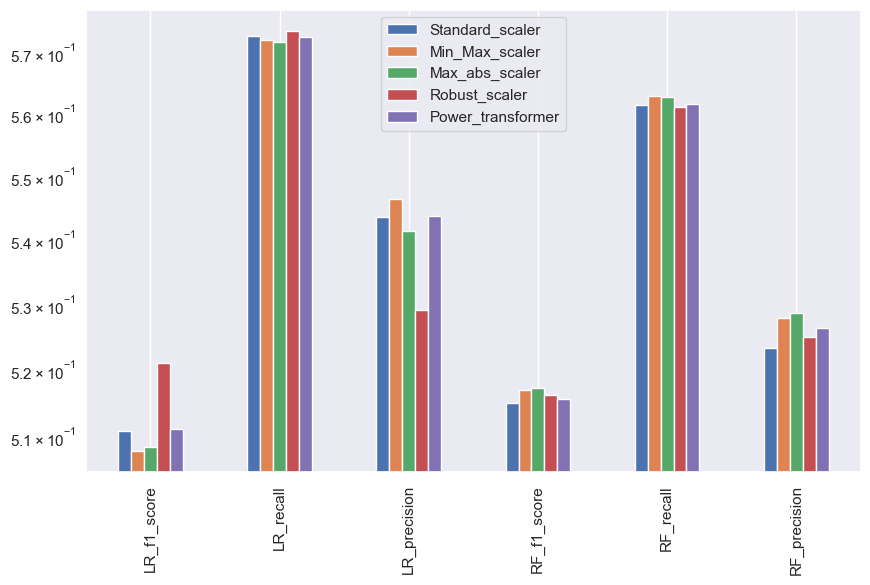

In [58]:
#y-axis Scaled for finding minute Differences
df_res.T.plot(kind='bar',figsize=(10,6),log='True')
#plt.yticks(['0.50', '0.53', '0.56', '0.59', '0.62'])

#### Following base models are built on one hot encoded medication columns

In [59]:
# Scaling numerical data using different scalers
scalers_list={'Standard' : StandardScaler(),'MaxAbs' :MaxAbsScaler(),'MinMax' :MinMaxScaler()
              ,'Power' :PowerTransformer(),'Robust' :RobustScaler()}
scaled_dfs={}
for name,scaler in scalers_list.items():
    scaled_features = scaler.fit_transform(df_num_copy)
    df_scaled=pd.DataFrame(scaled_features,columns=df_num_copy.columns)
    scaled_dfs[name] = df_scaled

In [60]:
# Creating dummies of categorical data
df_cat_copy_dummy=pd.get_dummies(df_cat_copy,drop_first=True)

In [61]:
cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
df_scores_LR = pd.DataFrame(columns=['LR_f1_score', 'LR_recall', 'LR_precision'])
df_scores_RF = pd.DataFrame(columns=['RF_f1_score', 'RF_recall', 'RF_precision'])
i = 0

models={'Logistic' :LogisticRegression(),'Random_Forest': RandomForestClassifier(n_estimators=30)}
for name,data_frame in scaled_dfs.items():
    #inside 1st loop selecting Scaled_data_frame
    df_ind=pd.concat([data_frame,df_cat_dummy],axis=1)
    X=df_ind
    y=df['readmitted']
    for model_name, model in models.items():
        #inside 2nd loop Selecting model
        cvs=cross_validate(model,X,y,cv=cv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
         
        if model_name == 'Logistic':
            df_scores_LR.loc[i] = [cvs['test_f1_weighted'].mean(), cvs['test_recall_weighted'].mean()
                            ,cvs['test_precision_weighted'].mean()]
            
        else:
            df_scores_RF.loc[i] = [cvs['test_f1_weighted'].mean(), cvs['test_recall_weighted'].mean()
                            ,cvs['test_precision_weighted'].mean()]
    i = i + 1


In [62]:
print("Various metrics for the base models are")
df_res = pd.concat([df_scores_LR, df_scores_RF],axis=1)
df_res.index = ['Standard_scaler','Min_Max_scaler','Max_abs_scaler','Robust_scaler','Power_transformer']
df_res.style.highlight_max(color = 'lightgreen', axis = 0)

Various metrics for the base models are


,LR_f1_score,LR_recall,LR_precision,RF_f1_score,RF_recall,RF_precision
Standard_scaler,0.509440,0.572421,0.544063,0.516971,0.560383,0.523827
Min_Max_scaler,0.508131,0.571761,0.543886,0.517381,0.560903,0.526710
Max_abs_scaler,0.507522,0.571541,0.544709,0.518226,0.561423,0.527949
Robust_scaler,0.520691,0.573321,0.522735,0.517668,0.561283,0.524329
Power_transformer,0.509470,0.572451,0.544176,0.517489,0.561493,0.524832


* From the results we can observe that the base models are giving almost **similar performance on the two different datasets** that we used (i.e one with label encoding and one with one hot encoding) 

<Axes: >

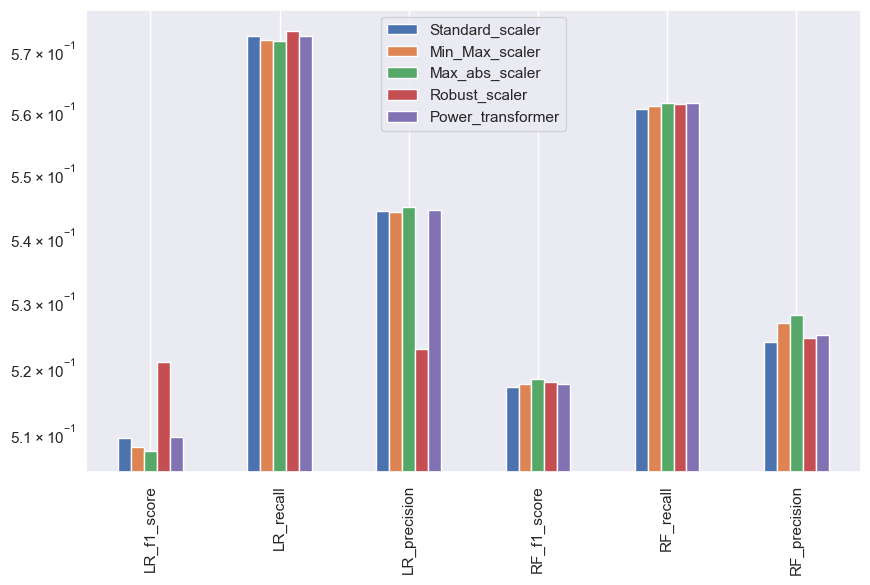

In [63]:
#y-axis Scaled for finding minute Differences
df_res.T.plot(kind='bar',figsize=(10,6), log = 'True')

# Feature Extraction

In [64]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,5,Not Available,Unknown,Referral,1,41,0,1,0,0,0,Diabetes,Others,Diabetes,1,NaN,NaN,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,No,No,0
1,Caucasian,Female,15,Emergency,Discharged to Home,Emergency room,3,59,0,18,0,0,0,Others,Diabetes,Others,9,NaN,NaN,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,Ch,Yes,1
2,AfricanAmerican,Female,25,Emergency,Discharged to Home,Emergency room,2,11,5,13,2,0,1,Others,Diabetes,Others,6,NaN,NaN,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,No,Yes,0
3,Caucasian,Male,35,Emergency,Discharged to Home,Emergency room,2,44,1,16,0,0,0,Others,Diabetes,Circulatory,7,NaN,NaN,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,Ch,Yes,0
4,Caucasian,Male,45,Emergency,Discharged to Home,Emergency room,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,NaN,NaN,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,Ch,Yes,0


### Health index

* If the frequency of person’s visit to the hospital is high then we can think of that person to be less healthier and less healthier patient tends to readmit quickly. Higher the health_index, higher the chance that person will get readmitted.

In [65]:
df['Health_index'] =(df['number_emergency']+df['number_inpatient']+df['number_outpatient'])

### Severity of disease

* Severity of disease is high if patient is spending lots of time in hospital and going through number of complicated test so, lets create severity of disease as one of the features.

In [66]:
df['severity_of_disease'] = (df['time_in_hospital'] + df['num_procedures'] + df['num_medications'] + df['num_lab_procedures'] + df['number_diagnoses'])

### Number of changes

* The patient which keeps going through changes(up/down) in proportion of medications will have a high chance to get readmitted.So I have engineered a new variable called as ‘number_of_changes’. This captures the number of medications whose proportion have changed. We calculated it for each patient.

In [67]:
medication_columns=df.loc[:, 'metformin':'metformin-pioglitazone']
number_of_changes = []
for i in range(len(df)):
    changeCount = 0
    for col in medication_columns.columns: 
        if df.iloc[i][col]==10 or df.iloc[i][col]==-10 :
            changeCount += 1
    number_of_changes.append(changeCount)

df['number_of_changes'] = number_of_changes

In [68]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,Health_index,severity_of_disease,number_of_changes
0,Caucasian,Female,5,Not Available,Unknown,Referral,1,41,0,1,0,0,0,Diabetes,Others,Diabetes,1,NaN,NaN,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,No,No,0,0,44,0
1,Caucasian,Female,15,Emergency,Discharged to Home,Emergency room,3,59,0,18,0,0,0,Others,Diabetes,Others,9,NaN,NaN,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,Ch,Yes,1,0,89,1
2,AfricanAmerican,Female,25,Emergency,Discharged to Home,Emergency room,2,11,5,13,2,0,1,Others,Diabetes,Others,6,NaN,NaN,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,No,Yes,0,3,37,0
3,Caucasian,Male,35,Emergency,Discharged to Home,Emergency room,2,44,1,16,0,0,0,Others,Diabetes,Circulatory,7,NaN,NaN,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,Ch,Yes,0,0,70,1
4,Caucasian,Male,45,Emergency,Discharged to Home,Emergency room,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,NaN,NaN,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,Ch,Yes,0,0,65,0


# Feature Selection

## Feature Selection using statistical test

In [69]:
df_test=df.copy()

In [70]:
# Converting target variable back to original dtype (object)
df_test['readmitted']=df_test['readmitted'].apply(lambda x:'NO' if x==0
                       else ('>30' if x==1
                            else '<30'))

In [71]:
num_cols= df_test.select_dtypes([np.number]).columns
cat_cols=df_test.select_dtypes([np.object_]).columns

In [72]:
selected_cat_cols=[]
for i in cat_cols:
    crosstab_values=pd.crosstab(df_test[i],df_test['readmitted']).values
    chi2,p_value,dof,expected=chi2_contingency(observed=crosstab_values,correction=False)
    
    if p_value<0.05:
        selected_cat_cols.append(i)
        print('{} column is significant with p_value'.format(i),p_value)
    
    else:
        print('{} column is insignificant with p_value'.format(i),p_value)
        
print('\r')
print('Selected categorical columns',selected_cat_cols)

race column is significant with p_value 4.9270709672666716e-54
gender column is significant with p_value 5.71637250849829e-08
admission_type_id column is significant with p_value 5.679673946795129e-76
discharge_disposition_id column is significant with p_value 2.8774128758334114e-157
admission_source_id column is significant with p_value 5.330933805987233e-237
diag_1 column is significant with p_value 1.0928261435775672e-106
diag_2 column is significant with p_value 5.5235968165629534e-52
diag_3 column is significant with p_value 2.168532972780592e-58
max_glu_serum column is significant with p_value 7.883795344401286e-10
A1Cresult column is significant with p_value 0.002521157384830703
change column is significant with p_value 4.0696180805403237e-41
diabetesMed column is significant with p_value 4.017429150447186e-75
readmitted column is significant with p_value 0.0

Selected categorical columns ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 

In [73]:
selected_num_cols=[]
for i in num_cols:
    gr1=df_test[df_test['readmitted']=='NO'][i]
    gr2=df_test[df_test['readmitted']=='>30'][i]
    gr3=df_test[df_test['readmitted']=='<30'][i]

    f_stat,pval=f_oneway(gr1,gr2,gr3)

    if pval<0.05:
        print('{} column is significant with p_value'.format(i),pval)
        selected_num_cols.append(i)
    else:
        print('{} column is insignificant with p_value'.format(i),pval)
        
print('\r')
print(selected_num_cols)


age column is significant with p_value 2.102311145132492e-34
time_in_hospital column is significant with p_value 1.2478040280189809e-80
num_lab_procedures column is significant with p_value 5.632025387515526e-50
num_procedures column is significant with p_value 3.2415072136602455e-37
num_medications column is significant with p_value 2.6226913700292574e-71
number_outpatient column is significant with p_value 1.2069519426857828e-156
number_emergency column is significant with p_value 1.9630535166844589e-246
number_inpatient column is significant with p_value 0.0
number_diagnoses column is significant with p_value 2.8961e-319
metformin column is significant with p_value 1.1622453111143808e-30
repaglinide column is significant with p_value 5.636740587575101e-10
nateglinide column is insignificant with p_value 0.45100411990372424
chlorpropamide column is insignificant with p_value 0.1976741147919624
glimepiride column is significant with p_value 0.016550478116821313
acetohexamide column is

In [74]:
# Total number of significant columns are
print('Significant columns are','\n',(selected_cat_cols+selected_num_cols))

Significant columns are 
 ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin', 'Health_index', 'severity_of_disease', 'number_of_changes']


In [75]:
select_cols=selected_cat_cols+selected_num_cols
df_fs=df[select_cols]
df_fs=pd.get_dummies(df_fs,drop_first=True)


#### Model building using statistically selected significant features

In [76]:
X=df_fs.drop('readmitted',axis=1)
y=df_fs['readmitted']

In [77]:
# Logistic regression model using significant columns
log_reg=LogisticRegression()
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
cvs_lrsc=cross_validate(log_reg,X,y,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_lrsc['test_f1_weighted'].mean())
print('recall_weighted:',cvs_lrsc['test_recall_weighted'].mean())
print('precision_weighted:',cvs_lrsc['test_precision_weighted'].mean())

f1_weighted: 0.4953664334286631
recall_weighted: 0.5668219845747977
precision_weighted: 0.5387083469573544


In [78]:
# Random forest model using significant columns
rf_sc=RandomForestClassifier(n_estimators=60)
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
cvs_rfsc=cross_validate(rf_sc,X,y,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_rfsc['test_f1_weighted'].mean())
print('recall_weighted:',cvs_rfsc['test_recall_weighted'].mean())
print('precision_weighted:',cvs_rfsc['test_precision_weighted'].mean())

f1_weighted: 0.523145668737761
recall_weighted: 0.5692717067065391
precision_weighted: 0.5415475281422335


In [79]:
sigcol_res=pd.DataFrame({"LR_SC":[(cvs_lrsc['test_f1_weighted'].mean()),(cvs_lrsc['test_recall_weighted'].mean()),(cvs_lrsc['test_precision_weighted'].mean())],
             "RF_SC":[(cvs_rfsc['test_f1_weighted'].mean()),(cvs_rfsc['test_recall_weighted'].mean()),(cvs_rfsc['test_precision_weighted'].mean())]},
             index=['f1_weighted','recall_weighted','precision_weighted'])
sigcol_res

,LR_SC,RF_SC
f1_weighted,0.495366,0.523146
recall_weighted,0.566822,0.569272
precision_weighted,0.538708,0.541548


## Feature Selection using RFE





In [80]:
df_dummy=pd.get_dummies(df,drop_first=True)
df_dummy.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,readmitted,Health_index,severity_of_disease,number_of_changes,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_Emergency,admission_type_id_New Born,admission_type_id_Not Available,admission_type_id_Trauma Center,admission_type_id_Urgent,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,discharge_disposition_id_Unknown,admission_source_id_Others,admission_source_id_Referral,admission_source_id_Transfer from hospital,diag_1_Diabetes,diag_1_Genitourinary,diag_1_Injury,diag_1_Musculoskelatal,diag_1_Neoplasms,diag_1_Others,diag_1_Respiratory,diag_2_Diabetes,diag_2_Genitourinary,diag_2_Injury,diag_2_Musculoskelatal,diag_2_Neoplasms,diag_2_Others,diag_2_Respiratory,diag_3_Diabetes,diag_3_Genitourinary,diag_3_Injury,diag_3_Musculoskelatal,diag_3_Neoplasms,diag_3_Others,diag_3_Respiratory,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_Norm,change_No,diabetesMed_Yes
0,5,1,41,0,1,0,0,0,1,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,0,44,0,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1,15,3,59,0,18,0,0,0,9,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,1,0,89,1,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,25,2,11,5,13,2,0,1,6,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,3,37,0,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True
3,35,2,44,1,16,0,0,0,7,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,0,0,70,1,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,45,1,51,0,8,0,0,0,5,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,0,0,65,0,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [81]:
X=df_dummy.drop('readmitted',axis=1)
y=df_dummy['readmitted']

In [82]:
# Finding optimum number of features for Logistic Regression using RandomizedsearchCV
log_reg=LogisticRegression()
rfe=RFE(estimator=log_reg)
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
params=[{'n_features_to_select':range(1,df_dummy.shape[1])}]
rsearch=RandomizedSearchCV(estimator=rfe,param_distributions=params,cv=scv,scoring='f1_weighted',n_jobs=4)
rsearch.fit(X,y)

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vikaskagawad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=RFE(estimator=LogisticRegression()), n_jobs=4,
                   param_distributions=[{'n_features_to_select': range(1, 76)}],
                   scoring='f1_weighted')

In [83]:
rsearch.best_params_

{'n_features_to_select': 42}

In [84]:
# Logistic regression model using RFE features
log_reg=LogisticRegression()
rfe=RFE(estimator=log_reg,n_features_to_select=rsearch.best_params_['n_features_to_select'])
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
cvs_lrrfe=cross_validate(rfe,X,y,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_lrrfe['test_f1_weighted'].mean())
print('recall_weighted:',cvs_lrrfe['test_recall_weighted'].mean())
print('precision_weighted:',cvs_lrrfe['test_precision_weighted'].mean())

f1_weighted: 0.50528394782032
recall_weighted: 0.5711914655372671
precision_weighted: 0.5470903711505799


In [85]:
rfe_lr=RFE(estimator=log_reg,n_features_to_select=rsearch.best_params_['n_features_to_select'])
rfe_lr.fit(X,y)

RFE(estimator=LogisticRegression(), n_features_to_select=42)

In [86]:
rfe_column=pd.DataFrame(rfe_lr.ranking_,index=X.columns,columns=['selected']).sort_values(by='selected')
rfelr_columns=rfe_column[rfe_column['selected']==1].index
rfelr_columns

Index(['admission_type_id_Emergency', 'race_Other', 'gender_Male', 'change_No',
       'admission_type_id_Not Available', 'admission_type_id_Urgent',
       'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Others',
       'admission_source_id_Referral',
       'admission_source_id_Transfer from hospital', 'diag_1_Diabetes',
       'diag_1_Genitourinary', 'diag_1_Injury', 'diag_1_Musculoskelatal',
       'race_Hispanic', 'diag_1_Neoplasms', 'diag_1_Respiratory',
       'diag_2_Diabetes', 'diag_2_Genitourinary', 'diag_2_Injury',
       'diag_2_Neoplasms', 'diag_2_Others', 'diag_2_Respiratory',
       'diag_3_Genitourinary', 'diag_3_Injury', 'diag_3_Neoplasms',
       'diag_3_Others', 'max_glu_serum_>300', 'A1Cresult_>8', 'A1Cresult_Norm',
       'diag_1_Others', 'race_Caucasian', 'diabetesMed_Yes',
       'number_of_changes', 'number_outpatient', 'number_inpatient',
       'number_diagnoses', 'chlorpropamide', 'acetohexamide',
 

In [87]:
# Finding optimum number of features for random_forest using RandomizedsearchCV
rf=RandomForestClassifier(n_estimators=50)
rfe_rf=RFE(estimator=rf)
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
params=[{'n_features_to_select':range(1,df_dummy.shape[1])}]
rsearch_rf=RandomizedSearchCV(estimator=rfe_rf,param_distributions=params,cv=scv,scoring='f1_weighted',n_jobs=-1)
rsearch_rf.fit(X,y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=RFE(estimator=RandomForestClassifier(n_estimators=50)),
                   n_jobs=-1,
                   param_distributions=[{'n_features_to_select': range(1, 76)}],
                   scoring='f1_weighted')

In [88]:
rsearch_rf.best_params_

{'n_features_to_select': 62}

In [89]:
# Random forest model using RFE features
rf=RandomForestClassifier(n_estimators=50)
rfe_rf=RFE(estimator=rf,n_features_to_select=66)
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
cvs_rf=cross_validate(rfe_rf,X,y,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_rf['test_f1_weighted'].mean())
print('recall_weighted:',cvs_rf['test_recall_weighted'].mean())
print('precision_weighted:',cvs_rf['test_precision_weighted'].mean())

f1_weighted: 0.5210198535099672
recall_weighted: 0.5670419618770844
precision_weighted: 0.5359688387270882


In [90]:
rfecol_res=pd.DataFrame({"LR_RFE":[(cvs_lrrfe['test_f1_weighted'].mean()),(cvs_lrrfe['test_recall_weighted'].mean()),(cvs_lrrfe['test_precision_weighted'].mean())],
             "RF_RFE":[(cvs_rf['test_f1_weighted'].mean()),(cvs_rf['test_recall_weighted'].mean()),(cvs_rf['test_precision_weighted'].mean())]},
             index=['f1_weighted','recall_weighted','precision_weighted'])
rfecol_res

,LR_RFE,RF_RFE
f1_weighted,0.505284,0.521020
recall_weighted,0.571191,0.567042
precision_weighted,0.547090,0.535969


## Model performnace with different feature selection methods

In [91]:
df_perform = pd.concat([sigcol_res,rfecol_res],axis=1)
df_perform.style.highlight_max(color = 'lightgreen', axis = 1)

,LR_SC,RF_SC,LR_RFE,RF_RFE
f1_weighted,0.495366,0.523146,0.505284,0.521020
recall_weighted,0.566822,0.569272,0.571191,0.567042
precision_weighted,0.538708,0.541548,0.547090,0.535969


# Analysis of final features selected and sampling of data

In [92]:
df=df[['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin', 'Health_index', 'severity_of_disease', 'number_of_changes']]
df.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,Health_index,severity_of_disease,number_of_changes
0,Caucasian,Female,Not Available,Unknown,Referral,Diabetes,Others,Diabetes,NaN,NaN,No,No,0,5,1,41,0,1,0,0,0,1,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,44,0
1,Caucasian,Female,Emergency,Discharged to Home,Emergency room,Others,Diabetes,Others,NaN,NaN,Ch,Yes,1,15,3,59,0,18,0,0,0,9,-20,-20,-20,-20,-20,-20,-20,-20,10,0,89,1
2,AfricanAmerican,Female,Emergency,Discharged to Home,Emergency room,Others,Diabetes,Others,NaN,NaN,No,Yes,0,25,2,11,5,13,2,0,1,6,-20,-20,-20,0,-20,-20,-20,-20,-20,3,37,0
3,Caucasian,Male,Emergency,Discharged to Home,Emergency room,Others,Diabetes,Circulatory,NaN,NaN,Ch,Yes,0,35,2,44,1,16,0,0,0,7,-20,-20,-20,-20,-20,-20,-20,-20,10,0,70,1
4,Caucasian,Male,Emergency,Discharged to Home,Emergency room,Neoplasms,Neoplasms,Diabetes,NaN,NaN,Ch,Yes,0,45,1,51,0,8,0,0,0,5,-20,-20,-20,0,-20,-20,-20,-20,0,0,65,0


In [93]:
df.describe(include='all')

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,Health_index,severity_of_disease,number_of_changes
count,100012,100012,100012,100012,100012,100012,100012,100012,5223,16862,100012,100012,100012.000000,100012.000000,100012.000000,100012.000000,100012.00000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000,100012.000000
unique,5,2,6,4,4,8,8,8,3,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Caucasian,Female,Emergency,Discharged to Home,Emergency room,Circulatory,Circulatory,Others,Norm,>8,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,74773,53814,52828,73571,56320,29867,31367,32652,2572,8147,53620,77192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.581860,65.827701,4.390323,42.945637,1.33102,15.984192,0.369596,0.198466,0.632844,7.410271,-15.976383,-19.688237,-18.959225,-17.460705,-17.863956,-18.535376,-18.727253,-19.937907,-9.415770,1.200906,72.061443,0.287575
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.685636,15.948193,2.974990,19.622915,1.70051,8.094037,1.264503,0.935959,1.262096,1.938134,8.179499,2.533789,4.528951,6.788382,6.325612,5.264748,4.926282,1.124724,10.995833,2.293539,25.465481,0.487888
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.000000,1.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,0.000000,4.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,55.000000,2.000000,31.000000,0.00000,10.000000,0.000000,0.000000,0.000000,6.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,0.000000,56.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,65.000000,4.000000,44.000000,1.00000,15.000000,0.000000,0.000000,0.000000,8.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-10.000000,0.000000,72.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,75.000000,6.000000,57.000000,2.00000,20.000000,0.000000,0.000000,1.000000,9.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,0.000000,2.000000,88.000000,1.000000


In [94]:
X=df.drop('readmitted',axis=1)
y=df['readmitted']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100,stratify=None)

In [96]:
X_test.describe(include='all')

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,change,diabetesMed,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,Health_index,severity_of_disease,number_of_changes
count,20003,20003,20003,20003,20003,20003,20003,20003,1065,3348,20003,20003,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000,20003.000000
unique,5,2,6,4,4,8,8,8,3,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Caucasian,Female,Emergency,Discharged to Home,Emergency room,Circulatory,Circulatory,Others,Norm,>8,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,15012,10771,10533,14705,11170,5895,6297,6450,528,1608,10742,15471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.739389,4.397790,42.859221,1.335400,16.073289,0.366095,0.191671,0.628406,7.426586,-16.013098,-19.711543,-18.937659,-17.471879,-17.914813,-18.513223,-18.742189,-19.946008,-9.354597,1.186172,72.092286,0.288257
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.007579,2.987005,19.587540,1.692352,8.025552,1.263426,0.861732,1.249036,1.943597,8.139447,2.408568,4.583030,6.779974,6.277930,5.289269,4.894413,1.061589,11.035679,2.234376,25.408930,0.485358
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,0.000000,8.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,0.000000,55.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-10.000000,0.000000,72.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,0.000000,2.000000,88.000000,1.000000


## Sample proportion tests to verify sample target is representation of population target

Ho: proportion of target in population= proportion of target in sample

H1: proportion of target in population != proportion of target in sample

In [97]:
# population counts
pop_class0=len(y[y==0])
pop_class1=len(y[y==1])
pop_class2=len(y[y==2])

In [98]:
#sample observations
samp_class0=len(y_test[y_test==0])
samp_class1=len(y_test[y_test==1])
samp_class2=len(y_test[y_test==2])

### Two sample z proprotion test

In [99]:
sm.stats.proportions_ztest(count = np.array([samp_class0, samp_class1]), 
                                             nobs = np.array([pop_class0, pop_class1]),  
                                             alternative ='two-sided')

(-0.8824364515866808, 0.37754083091609447)

In [100]:
sm.stats.proportions_ztest(count = np.array([samp_class0, samp_class2]), 
                                             nobs = np.array([pop_class0, pop_class2]),  
                                             alternative ='two-sided')

(-0.5889904904331402, 0.5558676528507815)

In [101]:
sm.stats.proportions_ztest(count = np.array([samp_class1, samp_class2]), 
                                             nobs = np.array([pop_class1, pop_class2]),  
                                             alternative ='two-sided')

(-0.003528111170329085, 0.9971849804084243)

### Chisquare test for goodness of fit

In [102]:
pop_total=pop_class0+pop_class1+pop_class2

In [103]:
samp_total=samp_class0+samp_class1+samp_class2

In [104]:
expected=[pop_class0/pop_total, pop_class1/pop_total,pop_class2/pop_total]
observed=[samp_class0/samp_total, samp_class1/samp_total,samp_class2/samp_total]

In [105]:
import scipy.stats as stats

stats.chisquare(f_obs=observed, f_exp=expected)

Power_divergenceResult(statistic=3.651858449160573e-05, pvalue=0.999981740874454)

Conclusion:


*   From description(.describe()), we can see that median/mode of sample and population are similar
*   From proportion test it is evident that we accept null hypothesis i.e sample is representation of population
*  From chisquare test as the p-value is greater than 0.05, it is evident that we fail to reject null hypothesis i.e sample is representation of population


In [106]:
X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

In [107]:
X_num=X_test.select_dtypes([np.number])
X_cat=X_test.select_dtypes([np.object_])

In [108]:
from sklearn.preprocessing import RobustScaler
rs=RobustScaler()
X_num=pd.DataFrame(rs.fit_transform(X_num),columns=X_num.columns)
X_num.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,Health_index,severity_of_disease,number_of_changes
0,0.5,0.50,-1.346154,-0.5,-0.888889,0.0,0.0,0.0,-0.333333,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.0,-1.303030,0.0
1,-1.0,-0.50,-0.307692,0.0,-0.555556,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.424242,1.0
2,1.0,-0.25,-1.038462,-0.5,-0.666667,0.0,2.0,4.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.5,3.0,-1.030303,0.0
3,0.0,-0.75,0.384615,-0.5,-0.333333,0.0,0.0,0.0,-0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.030303,0.0
4,-1.0,0.25,-0.807692,0.0,0.777778,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.0,-0.393939,0.0


In [109]:
X_cat=pd.get_dummies(X_cat,drop_first=True)
X_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_Emergency,admission_type_id_New Born,admission_type_id_Not Available,admission_type_id_Trauma Center,admission_type_id_Urgent,discharge_disposition_id_Discharged to Home,discharge_disposition_id_Other,discharge_disposition_id_Unknown,admission_source_id_Others,admission_source_id_Referral,admission_source_id_Transfer from hospital,diag_1_Diabetes,diag_1_Genitourinary,diag_1_Injury,diag_1_Musculoskelatal,diag_1_Neoplasms,diag_1_Others,diag_1_Respiratory,diag_2_Diabetes,diag_2_Genitourinary,diag_2_Injury,diag_2_Musculoskelatal,diag_2_Neoplasms,diag_2_Others,diag_2_Respiratory,diag_3_Diabetes,diag_3_Genitourinary,diag_3_Injury,diag_3_Musculoskelatal,diag_3_Neoplasms,diag_3_Others,diag_3_Respiratory,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_Norm,change_No,diabetesMed_Yes
0,False,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True
1,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
3,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [110]:
X_final=pd.concat([X_num,X_cat],axis=1)
#y_final=y_test.apply(lambda x:0 if x=='NO'
#                        else (1 if x=='>30'
#                            else 2))
y_final=y_test

In [111]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score,recall_score,f1_score



In [112]:
y_final.value_counts()

readmitted
0    10572
1     7148
2     2283
Name: count, dtype: int64

# Model building without tuning


In [114]:
models=[('MLPClassifier',MLPClassifier()),
        ('SVC',SVC()),
        ('AdaBoostClassifier',AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=50,random_state=100),random_state=100)),
        ('GradientBoostingClassifier',GradientBoostingClassifier(n_estimators=50 ,random_state=100)),
        ('RandomForestClassifier',RandomForestClassifier(n_estimators=50,random_state=100)),
        ('XGBClassifier',XGBClassifier(n_estimators=50,random_state=100))]

model_name=[]
F1_score=[]
Precision=[]
Recall=[]

cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)

for name,model in models:
    model=model
    cvs=cross_validate(model,X_final,y_final,cv=cv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
    model_name.append(name)
    F1_score.append(cvs['test_f1_weighted'].mean())
    Recall.append(cvs['test_recall_weighted'].mean())
    Precision.append(cvs['test_precision_weighted'].mean())

results=pd.DataFrame([F1_score,Recall,Precision],columns=model_name,index=['f1-score','recall','precision']).T 
results.sort_values('f1-score')

,f1-score,recall,precision
SVC,0.465054,0.552517,0.472697
MLPClassifier,0.502310,0.520422,0.492931
RandomForestClassifier,0.506484,0.553317,0.518209
AdaBoostClassifier,0.506642,0.558566,0.526153
GradientBoostingClassifier,0.511688,0.567365,0.526383
XGBClassifier,0.519501,0.560666,0.521453


# Model building with hyperparameter tuning

#### RANDOM FOREST CLASSIFIER

In [115]:

model=RandomForestClassifier(random_state=100)
params={'n_estimators':np.arange(10,120,20),'criterion': ['entropy', 'gini'],'max_depth':np.arange(10,40,5)}
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
randomforest_rs=RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=100,scoring='f1_weighted',cv=scv,random_state=100)
randomforest_rs.fit(X_final,y_final)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=RandomForestClassifier(random_state=100),
                   n_iter=100,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': array([10, 15, 20, 25, 30, 35]),
                                        'n_estimators': array([ 10,  30,  50,  70,  90, 110])},
                   random_state=100, scoring='f1_weighted')

In [116]:
randomforest_rs.best_params_

{'n_estimators': 110, 'max_depth': 25, 'criterion': 'gini'}

In [117]:
randomforest_model=RandomForestClassifier(n_estimators=randomforest_rs.best_params_['n_estimators'],
                                          criterion=randomforest_rs.best_params_['criterion'],
                                          max_depth=randomforest_rs.best_params_['max_depth'],
                                          class_weight='balanced')
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
cvs_rf=cross_validate(randomforest_model,X_final,y_final,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_rf['test_f1_weighted'].mean())
print('recall_weighted:',cvs_rf['test_recall_weighted'].mean())
print('precision_weighted:',cvs_rf['test_precision_weighted'].mean())

f1_weighted: 0.5108634307464291
recall_weighted: 0.5587160878908665
precision_weighted: 0.5153213269142097


#### ADABOOST CLASSIFIER

In [119]:
model=AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=70,
                                                               criterion='entropy',
                                                               max_depth=25,
                                                               class_weight='balanced'),random_state=100)

params={'n_estimators':np.arange(1,10),'learning_rate':np.arange(0.1,0.4,0.1)}
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
adaboost_rs=RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=100,scoring='f1_weighted',cv=scv,random_state=100)
adaboost_rs.fit(X_final,y_final)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                 criterion='entropy',
                                                                                 max_depth=25,
                                                                                 n_estimators=70),
                                                random_state=100),
                   n_iter=100,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                                        'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=100, scoring='f1_weighted')

In [120]:
adaboost_rs.best_params_

{'n_estimators': 3, 'learning_rate': 0.2}

In [122]:
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
adaboost_model=AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=70,
                                                               criterion='entropy',
                                                               max_depth=25,
                                                               class_weight='balanced')
                                  ,n_estimators=adaboost_rs.best_params_['n_estimators'],
                                  learning_rate=adaboost_rs.best_params_['learning_rate'],random_state=100)
cvs_ada=cross_validate(adaboost_model,X_final,y_final,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_ada['test_f1_weighted'].mean())
print('recall_weighted:',cvs_ada['test_recall_weighted'].mean())
print('precision_weighted:',cvs_ada['test_precision_weighted'].mean())

f1_weighted: 0.515961821366466
recall_weighted: 0.5645152730365881
precision_weighted: 0.5340641103718197


#### XGBOOST CLASSIFIER

In [123]:
model=XGBClassifier(random_state=100,objective='multi:softprob')
params={'n_estimators':np.arange(20,40,5),'learning_rate':[0.01,0.1,0.2,0.3],
        'max_depth':np.arange(5,20,5),'gamma': [0, 1]}
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
xgb_rs=RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=100,scoring='f1_weighted',cv=scv,random_state=100)
xgb_rs.fit(X_final,y_final)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importa...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob', ...),
                   n_iter=100,
                   param_distributions={'gamma': [0, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': array([ 5, 10, 15]),
                                        'n_estimators': array([20, 25, 30, 35])},
                   random_state=100, scoring='f1_weighted')

In [124]:
xgb_rs.best_params_

{'n_estimators': 35, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0}

In [125]:
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
xgb_model=XGBClassifier(n_estimators=xgb_rs.best_params_['n_estimators'],
                        learning_rate=xgb_rs.best_params_['learning_rate'],
                        max_depth=xgb_rs.best_params_['max_depth'],
                        gamma=xgb_rs.best_params_['gamma'],random_state=100)
cvs_xgb=cross_validate(xgb_model,X_final,y_final,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_xgb['test_f1_weighted'].mean())
print('recall_weighted:',cvs_xgb['test_recall_weighted'].mean())
print('precision_weighted:',cvs_xgb['test_precision_weighted'].mean())

f1_weighted: 0.5189680937041322
recall_weighted: 0.5657653230115939
precision_weighted: 0.5236393049836695


#### GRADIENT BOOSTING CLASSIFIER

In [170]:
model=GradientBoostingClassifier(tol=0.001)
params=[{'n_estimators':np.arange(20,30),'learning_rate':[0.1,0.2,0.3,0.4],
        'max_depth':np.arange(5,10),'max_features':[ 'sqrt', 'log2']}]
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
gradient_rs=RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=100,scoring='f1_weighted',cv=scv,random_state=100)
gradient_rs.fit(X_final,y_final)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=GradientBoostingClassifier(tol=0.001), n_iter=100,
                   param_distributions=[{'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                         'max_depth': array([5, 6, 7, 8, 9]),
                                         'max_features': ['sqrt', 'log2'],
                                         'n_estimators': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}],
                   random_state=100, scoring='f1_weighted')

In [171]:
gradient_rs.best_params_

{'n_estimators': 28,
 'max_features': 'sqrt',
 'max_depth': 7,
 'learning_rate': 0.3}

In [173]:
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
gradient_model=GradientBoostingClassifier(n_estimators=gradient_rs.best_params_['n_estimators'],
                                          learning_rate=gradient_rs.best_params_['learning_rate'],
                                          max_depth=gradient_rs.best_params_['max_depth'],
                                          max_features=gradient_rs.best_params_['max_features'],
                                          random_state=100)
cvs_gradient=cross_validate(gradient_model,X_final,y_final,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_gradient['test_f1_weighted'].mean())
print('recall_weighted:',cvs_gradient['test_recall_weighted'].mean())
print('precision_weighted:',cvs_gradient['test_precision_weighted'].mean())

f1_weighted: 0.5196817986196307
recall_weighted: 0.5588161653704957
precision_weighted: 0.5154844518970924


#### STACKING CLASSIFIER

In [130]:
base_learners=[('rf_model',RandomForestClassifier(criterion= 'entropy',
                                                  max_depth= 35,
                                                  n_estimators= 110))
,('adaboost',AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=70,
                                                               criterion='entropy',
                                                               max_depth=25,
                                                               class_weight='balanced'),n_estimators=5,learning_rate=0.3,random_state=100))
,('xgboost',XGBClassifier(n_estimators=35,learning_rate=0.3,max_depth=5,gamma=0,random_state=100))]

final_learner=GradientBoostingClassifier(n_estimators=28,learning_rate=0.3,max_depth=5,max_features='sqrt',random_state=100)

In [131]:
stack_model=StackingClassifier(estimators=base_learners,final_estimator=final_learner)
cvs_stackmodel=cross_validate(stack_model,X_final,y_final,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_stackmodel['test_f1_weighted'].mean())
print('recall_weighted:',cvs_stackmodel['test_recall_weighted'].mean())
print('precision_weighted:',cvs_stackmodel['test_precision_weighted'].mean())

f1_weighted: 0.5102832061510089
recall_weighted: 0.5559167902432712
precision_weighted: 0.5071670122012388


#### MLP CLASSIFIER

In [132]:
model= MLPClassifier(random_state=42)
params=[{
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}]
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
mlp_rs=RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=100,scoring='f1_weighted',cv=scv,random_state=100)
mlp_rs.fit(X_final,y_final)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=MLPClassifier(random_state=42), n_iter=100,
                   param_distributions=[{'activation': ['logistic', 'tanh',
                                                        'relu'],
                                         'alpha': [0.0001, 0.001, 0.01],
                                         'hidden_layer_sizes': [(50,), (100,),
                                                                (150,),
                                                                (200,)],
                                         'learning_rate': ['constant',
                                                           'adaptive'],
                                         'solver': ['adam', 'sgd']}],
                   random_state=100, scoring='f1_weighted')

In [133]:
mlp_rs.best_params_

{'solver': 'sgd',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (200,),
 'alpha': 0.0001,
 'activation': 'relu'}

In [168]:
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
mlp_model=MLPClassifier(hidden_layer_sizes=mlp_rs.best_params_['hidden_layer_sizes'],
                        learning_rate=mlp_rs.best_params_['learning_rate'],
                        solver=mlp_rs.best_params_['solver'],
                        alpha=mlp_rs.best_params_['alpha'],
                        activation=mlp_rs.best_params_['activation'],
                        random_state=100)
cvs_mlp=cross_validate(mlp_model,X_final,y_final,cv=scv,scoring=['f1_weighted','recall_weighted','precision_weighted'])
print('f1_weighted:',cvs_mlp['test_f1_weighted'].mean())
print('recall_weighted:',cvs_mlp['test_recall_weighted'].mean())
print('precision_weighted:',cvs_mlp['test_precision_weighted'].mean())

f1_weighted: 0.5198985369028265
recall_weighted: 0.5621657579388577
precision_weighted: 0.5263586931272501


In [174]:
data = {'Models':['RandomForest','AdaBoost','XgBoost','GradientBoost','StackingClassifier','MLPClassifier'],
       'f1_weighted':[cvs_rf['test_f1_weighted'].mean(),cvs_ada['test_f1_weighted'].mean(),
                     cvs_xgb['test_f1_weighted'].mean(),cvs_gradient['test_f1_weighted'].mean(),
                     cvs_stackmodel['test_f1_weighted'].mean(),cvs_mlp['test_f1_weighted'].mean()],
       'recall_weighted':[cvs_rf['test_recall_weighted'].mean(),cvs_ada['test_recall_weighted'].mean(),
                     cvs_xgb['test_recall_weighted'].mean(),cvs_gradient['test_recall_weighted'].mean(),
                     cvs_stackmodel['test_recall_weighted'].mean(),cvs_mlp['test_recall_weighted'].mean()],
       'precision_weighted':[cvs_rf['test_precision_weighted'].mean(),cvs_ada['test_precision_weighted'].mean(),
                     cvs_xgb['test_precision_weighted'].mean(),cvs_gradient['test_precision_weighted'].mean(),
                     cvs_stackmodel['test_precision_weighted'].mean(),cvs_mlp['test_precision_weighted'].mean()]}
tuning_res = pd.DataFrame(data)
tuning_res.sort_values(by='f1_weighted',ascending=False)


,Models,f1_weighted,recall_weighted,precision_weighted
5,MLPClassifier,0.519899,0.562166,0.526359
3,GradientBoost,0.519682,0.558816,0.515484
2,XgBoost,0.518968,0.565765,0.523639
1,AdaBoost,0.515962,0.564515,0.534064
0,RandomForest,0.510863,0.558716,0.515321
4,StackingClassifier,0.510283,0.555917,0.507167


# Oversampling the data

In [152]:
# USING SMOTE TO UPSAMPLE
from collections import Counter
from imblearn.over_sampling import SMOTE

In [153]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_final, y_final, test_size=0.4, random_state=100,stratify=None)

In [154]:
X_train_smote,X_test_smote,y_train_smote,y_test_smote=train_test_split(X_test1,y_test1,test_size=0.4,random_state=100,stratify=None)

In [155]:
Counter(y_test_smote)

Counter({0: 1658, 1: 1149, 2: 394})

In [156]:
# Before smote
Counter(y_train_smote)

Counter({0: 2530, 1: 1715, 2: 556})

In [157]:
sm=SMOTE()
X_smote,y_smote=sm.fit_resample(X_train_smote,y_train_smote) # Applying smote on train data

In [158]:
# After smote
Counter(y_smote)

Counter({0: 2530, 1: 2530, 2: 2530})

# Model building with oversampled data

#### RANDOM FOREST CLASSIFIER for SMOTE SAMPLE

In [159]:
model=RandomForestClassifier(random_state=100)
params={'n_estimators':np.arange(10,120,20),'criterion': ['entropy', 'gini'],'max_depth':np.arange(10,40,5)}
scv=StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
randomforest_rs=RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=100,scoring='f1_weighted',cv=scv,random_state=100)
randomforest_rs.fit(X_smote,y_smote)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=RandomForestClassifier(random_state=100),
                   n_iter=100,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': array([10, 15, 20, 25, 30, 35]),
                                        'n_estimators': array([ 10,  30,  50,  70,  90, 110])},
                   random_state=100, scoring='f1_weighted')

In [160]:
randomforest_rs.best_params_

{'n_estimators': 110, 'max_depth': 25, 'criterion': 'gini'}

In [161]:
randomforest_smote=RandomForestClassifier(n_estimators=110,
                                          criterion='gini',
                                          max_depth=35,
                                          class_weight='balanced')
randomforest_smote.fit(X_smote,y_smote)

RandomForestClassifier(class_weight='balanced', max_depth=35, n_estimators=110)

In [162]:
y_test_pred_smote=randomforest_smote.predict(X_test_smote)
print('F1_score of random_forest after smote is',f1_score(y_test_smote,y_test_pred_smote,average='weighted'))
print('Recall of random_forest after smote is',recall_score(y_test_smote,y_test_pred_smote,average='weighted'))
print('Precision of random_forest after smote is',precision_score(y_test_smote,y_test_pred_smote,average='weighted'))

F1_score of random_forest after smote is 0.5131882229415664
Recall of random_forest after smote is 0.5388940955951266
Precision of random_forest after smote is 0.5091882194327059


#### GRADIENT BOOSTING CLASSIFIER for SMOTE SAMPLE

In [146]:
gradient_model=GradientBoostingClassifier(n_estimators=27,learning_rate=0.1,max_depth=25,max_features='log2',random_state=100)
gradient_model.fit(X_smote,y_smote)

GradientBoostingClassifier(max_depth=25, max_features='log2', n_estimators=27,
                           random_state=100)

In [147]:
y_test_pred_smote=gradient_model.predict(X_test_smote)
print('F1_score of gradient boost after smote is',f1_score(y_test_smote,y_test_pred_smote,average='weighted'))
print('Recall of gradient boost after smote is',recall_score(y_test_smote,y_test_pred_smote,average='weighted'))
print('Precision of gradient boost after smote is',precision_score(y_test_smote,y_test_pred_smote,average='weighted'))

F1_score of gradient boost after smote is 0.49413428233906476
Recall of gradient boost after smote is 0.52077475788816
Precision of gradient boost after smote is 0.48863475336865125


In [148]:
gradient_model.fit(X_smote,y_smote)

GradientBoostingClassifier(max_depth=25, max_features='log2', n_estimators=27,
                           random_state=100)

##### Feature Importance

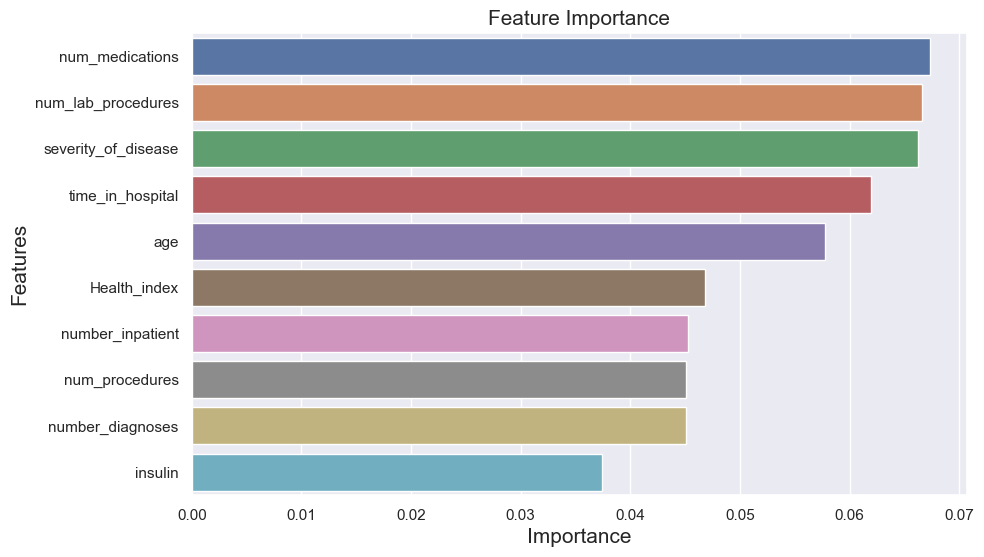

In [151]:
important_features = pd.DataFrame({'Features': X_train_smote.columns, 
                                   'Importance': gradient_model.feature_importances_})

important_features = important_features.sort_values('Importance', ascending = False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)



plt.savefig('feature_importance.png')
plt.show()

Since there is no increase in the results of SMOTE, we dont have to continue upsampling process
